In [0]:
import re
import nltk
import string

import pandas as pd
import datetime as dt
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

from pandas.plotting import scatter_matrix
from datetime import datetime  
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.decomposition import PCA

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet, brown, words
from collections import Counter

from gensim.models import Word2Vec

from bokeh.plotting import *
from bokeh.models import *
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import column, row, gridplot
from bokeh.palettes import Category20,brewer

nltk.download('stopwords')  
nltk.download('words')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolasgandar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/nicolasgandar/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [0]:
data='Data/russian-troll-tweets/IRAhandle_tweets_'
pickle_files='Pickles/'
WORD_FREQ = 'Data/wordfrea.xlsx'
plot_files='Plots/'

# Preprocessing, Word2Vec and most popular expressions

## Introduction
This part focuses on the textual content and representation of the tweets. The aim is to characterize the typical tweet of each troll category. First, the tweets are cleaned, a vocabulary as well as a colelction of hash-tags are build. Then a Word2Vec model is used to gather words by 'concepts'. Finally, each tweet is represented by the words it contains. A classifier is build to distinguish right and left trolls. 

## Preprocessing

### Data import and cleaning

The data is already pretty clean. We Select only the 'LeftTroll' and 'RightTroll' tweet after 2014.

In [0]:
def get_date(x):
    """From string to datatime.date()"""
    return dt.datetime.strptime(x, '%m/%d/%Y %H:%M').replace(minute=0, hour=0, second=0)

def cleaning_content(df,  right=True, left=True):
    df_tmp=df[df.language=='English'].drop(columns={'harvested_date', 'language'})
    df_tmp=df.loc[:,['publish_date','content', 'account_category', 'author']]

    #category
    if not left:
        df_tmp=df_tmp[(df_tmp.account_category=='RightTroll')]
    elif not right:
        df_tmp=df_tmp[(df_tmp.account_category=='LeftTroll')]
    else:        
        df_tmp=df_tmp[(df_tmp.account_category=='RightTroll') | (df_tmp.account_category=='LeftTroll')  ]

    #date 
    df_tmp['publish_date']=df_tmp.publish_date.apply(lambda x: get_date(x))
    #selecting after Oct 2014
    df_tmp=df_tmp[df_tmp.publish_date > dt.datetime(2014,10,1,0,0,0)]

    return df_tmp

Loading the data and merging (9) datasets.

In [0]:
df=pd.DataFrame()
for dataset in range(1,9): #loading every file 
    df_tmp=cleaning_content(pd.read_csv(data+str(dataset)+'.csv'))
    df=df.append(df_tmp, ignore_index=True)

Number of different trolls

In [0]:
print('There are {} trolls: {} right and {} left.'.format(df.author.unique().shape[0],\
                                                          df[df.account_category=='RightTroll'].author.unique().shape[0],\
                                                          df[df.account_category=='LeftTroll'].author.unique().shape[0]))
df.drop(columns='author', inplace=True)

There are 850 trolls: 620 right and 230 left.


Number of unique tweets

In [0]:
print('From {} tweets, {} are unique ({} tweets are duplicated).'\
      .format(df.shape[0],df.content.unique().shape[0],df.shape[0]-df.content.unique().shape[0]))

From 1131960 tweets, 935229 are unique (196731 tweets are duplicated).


In [0]:
nb_left=df[df.account_category=='LeftTroll'].shape[0]
nb_right=df[df.account_category=='RightTroll'].shape[0]

print('There are {} tweets. {} Right-trolls and {} Left-trolls.'\
      .format(df.shape[0], nb_right, nb_left))
df.head()

There are 1131960 tweets. 713177 Right-trolls and 418783 Left-trolls.


,publish_date,content,account_category
0,2017-10-01,"""We have a sitting Democrat US Senator on tria...",RightTroll
1,2017-10-01,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll
2,2017-10-01,Daughter of fallen Navy Sailor delivers powerf...,RightTroll
3,2017-10-01,JUST IN: President Trump dedicates Presidents ...,RightTroll
4,2017-10-01,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll


### Tweet text cleaning


The text is process as follow:
* hastags are exctracted (analysis to be done ...)
* the text is cleaned from punctuation (execpt '-')
* words are set to lower keys
* words that are not written with 'latin' caracters (emojiis, foreign alphabet...) are removed
* words that start/end with number are discarder
* links are discarded (start with 'http...')

In [0]:
link_numbers=('http', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-') # symbole that we want to avoid
stemmer = PorterStemmer() #stemmer
#stop words and 'rt'= retweet, 'amp'= encoding for @ 
stop_w=[word.replace('\'','') for word in stopwords.words('english')]+ ['', '&amp', 'amp','rt']

#load data frequency from http://www.wordfrequency.info
wordfrequency = pd.read_excel(WORD_FREQ, header=0, index_col=[0], usecols=3).dropna()
wordfrequency.Frequency = wordfrequency.Frequency/(wordfrequency.Frequency.sum())
wordfrequency.rename(columns={'\xa0\xa0\xa0Word' : 'Word', 'Part of speech' : 'PoS'}, inplace=True)
wordfrequency.Word = wordfrequency.apply(lambda row: row['Word'].replace("\xa0\xa0\xa0", ''), axis=1)

word_dictionary = list(set(words.words()))

In [0]:
def tokenize(text):
    """Split the the tweet into a list of (cleaned words). The hashtags are treated separatly
    and splitted in words"""
    
    text_cleaned = ''.join(ch for ch in text if ch not in '!"$%&\()*+,./:;<=>?@[\\]^_{|}~\'').split(' ') 
    
    #take the lower key, the english symbols and removing numbers
    #words_cleaned= [word.lower().encode('ascii',errors='ignore').decode() for word in text_cleaned \
    #        if not ( (word.startswith(link_numbers)) | (word.endswith(link_numbers))) ]
    
    #stemming words that are not in stop words
    words=[]
    for word in text_cleaned:   
        if word.startswith('#'): #treat hastags separatly
            if len(word)>1:# if is only a '#' charater, do not save it
                
                #Splitt the hastags 
                raw_hashtag=word.replace('#', '').lower().encode('ascii',errors='ignore').decode()
                words= words + hashtag_splitter(word) +  [stemmer.stem(raw_hashtag)]
        
        else: #words
            word_tmp=word.lower().encode('ascii',errors='ignore').decode() # take only english symbols
            
            #get rid of numbers characters and stop words
            if (not (word_tmp.startswith(link_numbers)) | (word_tmp.endswith(link_numbers))) \
                    & (word_tmp not in stop_w):
                words.append(stemmer.stem(word_tmp))#.lower().encode('ascii',errors='ignore').decode()))

    #words=[stemmer.stem(word.lower().encode('ascii',errors='ignore').decode()) for word in words \
           # if not ( (word.startswith(link_numbers)) | (word.endswith(link_numbers))) & (word not in stop_w) ]
    
    if len(words) > 0: #if the list of words is not empty
        return words
    else: #tweets that contains only links or emojiis ... that are empty
        pass
        
def hashtag_splitter(word):
    '''
    Receives an hashtag, removes '#' and check if the word is in dic.
    If not, try to split it according to uppercases.
    E.g: #BlackLivesMatters --> black, live, matter
         #NFLProtest --> nfl, protest
         #Stemming --> stem
    '''
    new_wordlist=[]
    hashtag = word.replace('#', '')
    
    #Is the hashtag a word itself?
    if (hashtag.lower() in word_dictionary):
        new_wordlist.append(stemmer.stem(hashtag.lower()))
    
    #If not, let's split it    
    else:
        split = []
        upper = []
        new_word = []
        
        #going over each char in the hashtag
        for idx, char in enumerate(hashtag):
           
            #If char is uppercase, store it in potential word beggining
            if char.isupper():
                upper.append(char)
                #Upper means potentially the end of a word, if this is the case, store ex-new_word
                if len(new_word) !=0:
                    split.append(''.join(new_word))
                    new_word = []
            else:
                #if char is not uppercase, not precedated by uppercase
                if len(upper) == 0:
                    new_word.append(char)
                    #end of hashtag
                    if idx == (len(hashtag)-1):
                        split.append(''.join(new_word))
                else:
                    #If there was an ongoing uppercased word, we save it and start a new word with the 
                    # previous uppercased char as first char of new word
                    if len(upper) != 0:
                        split.append(''.join(upper[:-1]))
                        new_word.append(upper[-1])
                        new_word.append(char)
                        upper = []
                    else:
                        print('Error')

        new_wordlist = new_wordlist + [stemmer.stem(word.lower().encode('ascii',errors='ignore').decode()) for word in split if word.lower() not in \
                (wordfrequency[:150].Word.values.tolist() + [''] + ['i'] + stop_w)]
    return new_wordlist

def build_vocab(tweets, min_occurence=10):
    """Gathers all the words that are more frequent than min_occurence"""
    
    filename=pickle_files+'vocabulary_'+str(min_occurence)+'.pkl'

    voc_raw=[]
    for words in tweets:
        if words: #if not None
            voc_raw+=words # add to voca
    count_=Counter(voc_raw) #count frequency
    
    vocabulary=[word for word in count_.keys() if count_[word] >= min_occurence]
    
    with open(filename, 'wb') as voc:
            pickle.dump(vocabulary, voc, pickle.HIGHEST_PROTOCOL)
    print('Vocabulary saved -->')
    
    return vocabulary


def get_vocabulary(tweets, min_count=10):
    """Recovers the vocabulary from pickles"""
    filename=pickle_files+'vocabulary_'+str(min_count)+'.pkl'
    
    try:
        with open(filename, 'rb') as voc:
            vocabulary=pickle.load(voc) 
        print("Vocab loaded <---")
            
    except: 
        vocabulary= build_vocab(tweets)
        
    return vocabulary

In [ ]:
df['Clean_tweet']=df.content.apply(lambda content: tokenize(content))#list of words for each tweet

In [0]:
#gets the vocabulary 
vocabulary=get_vocabulary(df.Clean_tweet, min_count=10)
vocabulary=build_vocab(df.Clean_tweet, min_occurence=10)
print('Vocabulary is {} long'.format(len(vocabulary)))

In [0]:
#filter out elements less frequent than 10 times
df['Clean_tweet']=df.Clean_tweet.apply(lambda list_word: [word for word in list_word if word in vocabulary]\
                                                           if list_word else None)

### Hashtags #ADA

In [0]:
def get_hastag_collection(text, nb_min=10):
    """Defines the collection of hastags in the entire dataset. 
    Try to load the hastag list if its available"""
    
    filename=pickle_files+'hastag_collection_count_'+str(nb_min)+'.pkl'
    
    try :
        with open(filename, 'rb') as h:
            count_=pickle.load(h) 
        print('Pickle loaded <--')
            
    except:
        hashtags = []
        text = text.split()
        for words in text:
            new_hash = re.match("#[A-Za-z0-9\-\.\_]+", words)
            if new_hash:
                hashtags.append(new_hash.group(0))
        count_=Counter(hashtags)

        with open(filename, 'wb') as h:
            pickle.dump(count_, h, pickle.HIGHEST_PROTOCOL) #saving the tweet_vect
        
    return [hashtag for hashtag in count_.keys() if count_[hashtag] >= nb_min]

def hashtag_extractor(text,hastag_coll):
    """Extract hastags if they happend more than nb_min times (over the whole data)"""
    hashtags = []
    for word in text.split():
        if (word.startswith('#')) & (word.encode('ascii',errors='ignore').decode() in hastag_coll):
            hashtags.append(word.encode('ascii',errors='ignore').decode())
    return hashtags

def hastag_orientation(df, hashtags_collec):
    """Defines if a words have been used more by Right or Left trolls.
    LeftTroll: -1 ≤ score ≤ 1 : RightTroll"""
    
    tot_hash=len(hashtags_collec)
    hash_party= pd.DataFrame(np.zeros(tot_hash), columns={'Score'}, index=hashtags_collec)

    hash_=[]
    for tweet in df[(df.hashtags.isnull()==False) & (df.account_category=='RightTroll')].hashtags:
        hash_+=tweet
    count=pd.DataFrame.from_dict(Counter(hash_), columns={'R#'}, orient='index')

    hash_party=hash_party.merge(count, how='left', right_index=True, left_index=True)

    hash_=[]
    for tweet in df[(df.hashtags.isnull()==False) & (df.account_category=='LeftTroll')].hashtags:
        hash_+=tweet
    count=pd.DataFrame.from_dict(Counter(hash_), columns={'L#'}, orient='index')

    hash_party=hash_party.merge(count, how='left', right_index=True, left_index=True)
    
    hash_party.fillna(0,inplace=True)
    hash_party['Score']=hash_party.apply(lambda row:  ((row['R#']/nb_right)-(row['L#']/nb_left))/((row['R#']/nb_right)+(row['L#']/nb_left)) if (row['R#']+row['L#'] >0)  else 0 , axis=1)

    return hash_party

def save_df(df, filename=pickle_files+'df.pkl'):
    
    with open(filename, 'wb') as d:
        pickle.dump(df, d, pickle.HIGHEST_PROTOCOL)
    print('--> DafaFrame saved as '+ filename)
    
def load_df(filename=(pickle_files+'df.pkl')):
    with open(pickle_files+'df.pkl', 'rb') as d:
        df=pickle.load(d)
    print(' DafaFrame loaded <--')
    return df

Exctract hastags that happend more than X (=10) time 

In [0]:
hashtags_collec=get_hastag_collection(' '.join([tweet for tweet in df.content]), 10)

Try to load the _df.pkl_ before running the next cell.

In [0]:
df['hashtags']=df.content.apply(lambda text: hashtag_extractor(text,hashtags_collec))

**Get Hashtag political orientation**

In [0]:
#defines a color according to their score
hashtags=hastag_orientation(df, hashtags_collec)
hashtags['colors#'] = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.RdBu(mpl.colors.Normalize()(hashtags['Score'].apply(lambda x: -x).tolist()))
]
hashtags.head()

### Dataframe final step

Start here to avoid the pre-process.

In [0]:
#Loading everything:
def load_df(filename=(pickle_files+'df.pkl')):
    with open(filename, 'rb') as d:
        df=pickle.load(d)
    print(' DafaFrame loaded <--')
    return df

def load_vocab(min_count=10):
    """Recovers the vocabulary from pickles"""
    filename=pickle_files+'vocabulary_'+str(min_count)+'.pkl'

    with open(filename, 'rb') as voc:
        vocabulary=pickle.load(voc) 
    print(' Vocabulary loaded <--')
    return vocabulary

In [ ]:
save_df(df, pickle_files+'df_final.pkl')

In [0]:
df.head()

In [0]:
df=load_df(pickle_files+'df_final.pkl')
vocabulary=load_vocab()

nb_left=df[df.account_category=='LeftTroll'].shape[0]
nb_right=df[df.account_category=='RightTroll'].shape[0]

df.head()

 DafaFrame loaded <--
 Vocabulary loaded <--


,publish_date,content,account_category,Clean_tweet,hashtags,Mentioned
0,2017-10-01,"""We have a sitting Democrat US Senator on tria...",RightTroll,"[sit, democrat, senat, trial, corrupt, bare, p...",[],[@nedryun]
1,2017-10-01,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll,"[marshawn, lynch, game, anti-trump, shirt, sag...",[],[]
2,2017-10-01,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,"[fallen, navi, sailor, power, anthem, nfl, pac...",[#BoycottNFL],[]
3,2017-10-01,JUST IN: President Trump dedicates Presidents ...,RightTroll,"[presid, trump, presid, tournament, texa, puer...",[],[]
4,2017-10-01,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll,"[anthem, anthem]",[#StandForOurAnthem],[]


### Tweet accounts mentioned @ADA

In [0]:
def at_extractor(content):
    """Extract @Names (the twitter account that is directly mentioned)"""
    at = []
    content=''.join(ch for ch in content if ch not in '!"$%&\()*+,./:;<=>?#[\\]^{|}~\'').split(' ') 
    
    for word in content:
        if (word.startswith('@')) & (len(word)>1):  
              at.append(word.encode('ascii',errors='ignore').decode())
        
        #tweet that are quoted
        elif(word.startswith('\'@') | word.startswith('\"@')) & (len(word)>1):
            at.append(word[1:].encode('ascii',errors='ignore').decode())

    return at

def at_orientation(at_left, at_right):
    """Defines if a @word have been used more by Right or Left trolls.
    LeftTroll: -1 ≤ score ≤ 1 : RightTroll"""
        
    #right
    count_r=pd.DataFrame.from_dict(Counter(at_right), columns={'R@'}, orient='index')
    
    #left
    count_l=pd.DataFrame.from_dict(Counter(at_left), columns={'L@'}, orient='index')

    #all
    at_oritation=count_r.merge(count_l, how='left', right_index=True, left_index=True)
    
    at_oritation.fillna(0,inplace=True)
    at_oritation['Score']=at_oritation.apply(lambda row:  ((row['R@']/nb_right)-(row['L@']/nb_left))/((row['R@']/nb_right)+(row['L@']/nb_left)) if (row['R@']+row['L@'] >0)  else 0 , axis=1)

    return at_oritation



In [0]:
df['Mentioned']=df.content.apply(lambda tweet: at_extractor(tweet))

In [0]:
at_left=sum(df[(df.account_category=='LeftTroll')].Mentioned.tolist(), [])

In [0]:
at_right=sum(df[(df.account_category=='RightTroll')].Mentioned.tolist(), [])

In [0]:
at_all=at_orientation(at_left, at_right)
at_all['colors@'] = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.RdBu(mpl.colors.Normalize()(at_all['Score'].apply(lambda x: -x).tolist()))
]

In [0]:
at_all.head()

### Word political orientation

Each word gets characterize by a *Score* that should represent it category: <br>
        
 * LeftTroll: -1 ≤ score ≤ 1 : RightTroll
        
To get rid of neutral words, we take only words that are characteristic of one the two groups : 

* |Score| ≥ 0.25

In [0]:
def word_orientation(df, vocab):
    """Defines if a words have been used more by Right or Left trolls.
    LeftTroll: -1 ≤ score ≤ 1 : RightTroll"""
    
    tot_words=len(vocab)
    words_party= pd.DataFrame(np.zeros(tot_words), columns={'Score'},index=vocab) #vocabulary dataframe

    #Right trolls words
    voc=[]
    for tweet in df[(df.Clean_tweet.isnull()==False) & (df.account_category=='RightTroll')].Clean_tweet:
        voc+=tweet
    count=pd.DataFrame.from_dict(Counter(voc), columns={'R'}, orient='index') #get word frequency
    words_party=words_party.merge(count, how='left', right_index=True, left_index=True) #add it to dataframe

    #Left trolls words
    voc=[]
    for tweet in df[(df.Clean_tweet.isnull()==False) & (df.account_category=='LeftTroll')].Clean_tweet:
        voc+=tweet
    count=pd.DataFrame.from_dict(Counter(voc), columns={'L'}, orient='index')

    words_party=words_party.merge(count, how='left', right_index=True, left_index=True)
    words_party.fillna(0,inplace=True)# replace Nans
    
    #Computes the score of each word
    words_party['Score']=words_party.apply(lambda row: ((row['R']/nb_right)-(row['L']/nb_left))/((row['R']/nb_right)+(row['L']/nb_left)), axis=1)

    return words_party

**Remove words that are not politically oriented:**

In [0]:
#quantifies de correlation between each category (right or left)
vocabulary_oriented=word_orientation(df,vocabulary )

#take words that are oriented. Remove neutral words : |orientation| < 0.25
vocabulary_oriented=vocabulary_oriented[np.abs(vocabulary_oriented.Score) >= 0.25] 
print('The oriented vocabulary is {} long (before {} long.)'.format(len(vocabulary_oriented), len(vocabulary)))

#remove words that are not kept in the vocabulary oriented
df['Clean_tweet']=df.Clean_tweet.apply(lambda list_word: \
                                       [word for word in list_word if word in vocabulary_oriented.index]\
                                        if list_word else None)

## Word2Vec

### Building model

In [0]:
#non empty clean tweet
embedding=100
tweets=df[df.Clean_tweet.isnull()==False]['Clean_tweet'] #take non empty clean tweet
model = Word2Vec(tweets.tolist(), min_count=1, size=embedding)
model.train(tweets.tolist(), epochs=10, total_examples=model.corpus_count)

The two following methodes were tried to have a better representations of the words (after the PCA).

In [0]:
def normalize(vectors):
    """Normalize the word vectors"""
    norm=np.linalg.norm(model.wv.vectors, ord=2, axis=1)
    vect_norm=np.zeros(vectors.shape)
    for i in range(vectors.shape[0]):
        vect_norm[i]=(vectors[i]/norm[i])
    return vect_norm

def standardize(vectors):
    """Standardize the word vectors"""
    return (vectors-np.mean(vectors,axis=0))/np.std(vectors,axis=0)

#norm_vectors=normalize(model.wv.vectors)
sd_vectors=standardize(model.wv.vectors)

Perfom a PCA on the model's vectors for plotting. Each word gets a color according to its orientation score (defiend above)

In [0]:
word_vec = pd.DataFrame(model.wv.vectors, index=model.wv.vocab) #for tweet vector

# fit a PCA and tke the first 9 PCs
Nb_Pcs=9
pca = PCA(n_components=Nb_Pcs)

In [0]:
result = pd.DataFrame(pca.fit_transform(sd_vectors))#, columns={'X','Y','Z'})
result.columns=['Pc'+str(i) for i in range(1,Nb_Pcs+1)]
result.index=model.wv.vocab


#defines a color according to their score
result=result.merge(vocabulary_oriented, how='right', right_index=True, left_index=True)
result['colors'] = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.RdBu(mpl.colors.Normalize()(result['Score'].apply(lambda x: -x).tolist()))
]

In [0]:
pca.explained_variance_ratio_ *100 # % of variance explained by each componened --> very low

In [0]:
sum(pca.explained_variance_ratio_ *100) #total variance explained by all the considered PCs

The total variance eplained by the 9 PCs is relatively low. The visualization on 2 dimensions will not be neat as more than half of the data variability will not be represented. Even if two points (representing words) will appear close to each other in 2D, they might be realy distant in the total 100 dimensions space

In [0]:
result.head() #data frame quick look

### Plotting:

#### Word space (PCA)

In [0]:
# ---- X vs Y ----
pXY = figure(plot_width=900, plot_height=450) # x_axis_type='datetime')
pXY.title.text = 'Tweets topic clusters'

right_word=result[result['Score'] >= 0.5 ]
left_word=result[result['Score']<=-0.5]

source_R = ColumnDataSource(data=right_word)
pXY.scatter(x='Pc1', y='Pc2', source=source_R, fill_color='colors', legend='Right', fill_alpha=0.6, line_color=None)

source_L = ColumnDataSource(data=left_word)
pXY.scatter(x='Pc1', y='Pc2', source=source_L, fill_color='colors',legend='Left', fill_alpha=0.6, line_color=None)


pXY.legend.location = 'top_left'
pXY.legend.click_policy='hide'
pXY.xaxis.axis_label='PC1'
pXY.yaxis.axis_label='PC2'

hover_tool=tools.HoverTool(
    tooltips=[('Word', '@index')],
    formatters={'index' : 'printf', },
    mode='mouse'
)

pXY.tools.append(hover_tool)

# ---- X vs Z ----
pXZ = figure(plot_width=450, plot_height=450) # x_axis_type='datetime')
pXZ.title.text = 'Tweets topic clusters'


source_R = ColumnDataSource(data=right_word)
pXZ.scatter(x='Pc1', y='Pc3', source=source_R, fill_color='colors', legend='Right', fill_alpha=0.6, line_color=None)

source_L = ColumnDataSource(data=left_word)
pXZ.scatter(x='Pc1', y='Pc3', source=source_L, fill_color='colors',legend='Left', fill_alpha=0.6, line_color=None)


pXZ.legend.location = 'top_left'
pXZ.legend.click_policy='hide'
pXZ.xaxis.axis_label='PC1'
pXZ.yaxis.axis_label='PC3'

# --- Y vs Z ----
pYZ = figure(plot_width=450, plot_height=450) # x_axis_type='datetime')
pYZ.title.text = 'Tweets topic clusters'



source_R = ColumnDataSource(data=right_word)
pYZ.scatter(x='Pc2', y='Pc3', source=source_R, fill_color='colors', legend='Right', fill_alpha=0.6, line_color=None)

source_L = ColumnDataSource(data=left_word)
pYZ.scatter(x='Pc2', y='Pc3', source=source_L, fill_color='colors',legend='Left', fill_alpha=0.6, line_color=None)


pYZ.legend.location = 'top_left'
pYZ.legend.click_policy='hide'
pYZ.xaxis.axis_label='PC2'
pYZ.yaxis.axis_label='PC3'

hover_tool=tools.HoverTool(
    tooltips=[('Word', '@index')],
    formatters={'index' : 'printf', },
    mode='mouse'
)

pYZ.tools.append(hover_tool)
pXZ.tools.append(hover_tool)

output_file('Plots/Word2Vec_word_space.html')
save(gridplot([[pXY],[ pXZ, pYZ]]))

**Plot is [here](Plots/Word2Vec_word_space.html)**

Plotting every combinaison of PCs together to try to find a cluster.

In [0]:
ax=scatter_matrix(result.drop(columns={'Score','R', 'L', 'colors'}), figsize=[18,18], marker='.', c=result.colors)
plt.show()

We cannot see any cluster. The 2D reduction of 100D is not good enough.

#### Tweets representation in Word2Vec space

Represent each tweet with K components (the number of word embedding dimensions) as the mean of each word's compenents.

In [0]:
def get_tweet_vec(df,embedding, load=False):
    
    filename=pickle_files+'tweets_vec_'+str(embedding)+'.pkl'
    
    if load:
        try:
            with open(filename, 'rb') as tv:
                tweets_vec=pickle.load(tv)
            print('Tweet_vec loaded <--')

        except:
            print('Pikle not found')
            tweets_vec= np.zeros((df.shape[0],embedding)) # nb_words x K 
            zero_vec=np.zeros(embedding)

            for  idx, words in enumerate(df.Clean_tweet):
                if words:  #if not None   
                    tweets_vec[idx,:]=np.mean(word_vec.loc[words,:], axis=0) # mean over words-vectors (the weighting is included)
                else:
                    tweets_vec[idx,:]=zero_vec

            with open(filename, 'wb') as tv:
                pickle.dump(tweets_vec, tv, pickle.HIGHEST_PROTOCOL) #saving the tweet_vect
            print('Tweet_vec saved -->')
                
    else:
        tweets_vec= np.zeros((df.shape[0],embedding)) # nb_words x K 
        zero_vec=np.zeros(embedding)

        for  idx, words in enumerate(df.Clean_tweet):
            if words:  #if not None   
                tweets_vec[idx,:]=np.mean(word_vec.loc[words,:], axis=0) # mean over words-vectors (the weighting is included)
            else:
                tweets_vec[idx,:]=zero_vec

        with open(filename, 'wb') as tv:
            pickle.dump(tweets_vec, tv, pickle.HIGHEST_PROTOCOL) #saving the tweet_vect
        print('Tweet_vec saved -->')
        
    return tweets_vec

In [0]:
tweets_vec=get_tweet_vec(df, embedding, load=True)

In [0]:
tweets_vec=standardize(tweets_vec)

In [0]:
pca = PCA(n_components=3)

tweet_vec_pca = pd.DataFrame(pca.fit_transform(model.wv.vectors),columns={'X','Y','Z'})
tweet_vec_pca['category']=df.account_category
tweet_vec_pca['colors']=tweet_vec_pca.apply(lambda row: '#ff6347' if row['category']=='RightTroll' else '#1E90FF', axis=1)
tweet_vec_pca['tweet']=df.content

In [0]:
tweet_vec_pca.head()

In [0]:
# ---- PC1 vs PC2 ---- #
pXY = figure(plot_width=500, plot_height=450)
pXY.title.text = 'Tweets topic clusters'


source_pca_R = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'RightTroll'])
pXY.scatter(x='X', y='Y', source=source_pca_R, fill_color='colors', legend='RightTroll', fill_alpha=0.6, line_color=None)

source_pca_L = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'LeftTroll'])
pXY.scatter(x='X', y='Y', source=source_pca_L, fill_color='colors', legend='LeftTroll', fill_alpha=0.6, line_color=None)


pXY.legend.location = 'top_left'
pXY.legend.click_policy='hide'
pXY.xaxis.axis_label='PC1'
pXY.yaxis.axis_label='PC2'

hover_tool=tools.HoverTool(
    tooltips=[('Tweet', '@tweet')],
    formatters={'tweet' : 'printf', },
    mode='mouse'
)

pXY.tools.append(hover_tool)

# ---- PC1 vs PC3 ---- #
pXZ = figure(plot_width=500, plot_height=450)
pXZ.title.text = 'Tweets topic clusters'


source_pca_R = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'RightTroll'])
pXZ.scatter(x='X', y='Z', source=source_pca_R, fill_color='colors', legend='RightTroll', fill_alpha=0.6, line_color=None)

source_pca_L = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'LeftTroll'])
pXZ.scatter(x='X', y='Z', source=source_pca_L, fill_color='colors', legend='LeftTroll', fill_alpha=0.6, line_color=None)


pXZ.legend.location = 'top_left'
pXZ.legend.click_policy='hide'
pXZ.xaxis.axis_label='PC1'
pXZ.yaxis.axis_label='PC3'


pXZ.tools.append(hover_tool)

output_file('Plots/Word2Vec_Tweets.html')
save(row(pXY, pXZ))

Plot can be seen [here](Plots/Word2Vec_Tweets.html)

In [0]:
ax=scatter_matrix(tweet_vec_pca.drop(columns={'tweet', 'category'}), figsize=[10,10], marker='.', c=tweet_vec_pca.colors)
plt.show()

## Most frequent words & hashtags per category 

### Most frequent words, #hashtags and @mentioning

#### Use of POTUS (president of the US) twitter account

In [0]:
#Trump presidency began on the 20th of January 2017
trump_presidency = df[df.publish_date > datetime.strptime('2017-20-01', '%Y-%d-%m')]
obama_presidency = df[df.publish_date < datetime.strptime('2017-20-01', '%Y-%d-%m')]

def POTUS_count():
    '''
    Counts the number of appearance of @POTUS for trump and obama presidency by account_category
    '''
    potus_counter = Counter({'Trump-RightTroll': 0, 'Trump-LeftTroll': 0, 'Obama-RightTroll': 0, 'Obama-LeftTroll': 0})
    for row in range(len(obama_presidency)):
        if len(obama_presidency.iloc[row].Mentioned) > 0:
            for mention in obama_presidency.iloc[row].Mentioned:
                if mention == '@POTUS':
                    account_category = obama_presidency.iloc[row].account_category
                    potus_counter['Obama-'+account_category] += 1
    for row in range(len(trump_presidency)):
        if len(trump_presidency.iloc[row].Mentioned) > 0:
            for mention in trump_presidency.iloc[row].Mentioned:
                if mention == '@POTUS':
                    account_category = trump_presidency.iloc[row].account_category
                    potus_counter['Trump-'+account_category] += 1
    return potus_counter

In [0]:
potus_counter = POTUS_count()

In [0]:
# Displaying results as a confusion matrix
tot = sum(potus_counter.values())
trump_left_potus = round((100*potus_counter['Trump-LeftTroll'])/tot,2)
trump_right_potus = round((100*potus_counter['Trump-RightTroll'])/tot,2)
obama_left_potus = round((100*potus_counter['Obama-LeftTroll'])/tot,2)
obama_right_potus = round((100*potus_counter['Obama-RightTroll'])/tot,2)
potus_array = pd.DataFrame(data = {'Trump': [trump_right_potus, trump_left_potus, trump_right_potus+trump_left_potus], \
                                   'Obama': [obama_right_potus, obama_left_potus, obama_right_potus+obama_left_potus], \
                                   'Category Sum': [trump_right_potus+obama_right_potus, trump_left_potus+obama_left_potus, 100]},\
                          index = ["Right Trolls", "Left Trolls", "President Sum"])
potus_array

#### Plottings

In [0]:
#Def of at and hash
top_people_right = ['@realDonaldTrump', '@POTUS', '@HillaryClinton', '@CNN', '@FoxNews', '@YouTube', '@CNNPolitics', \
             '@seanhannity', '@BreitbartNews', '@mashable']

top_people_left = ['@YouTube', '@TalibKweli', '@realDonaldTrump', '@josephjett', '@POTUS', '@deray',\
                   '@docrocktex26', '@ShaunKing', '@HillaryClinton', '@BlackGirlNerds']

top_people_expl_right = ["Donald Trump's personal account", 'President Of The United State twitter account; used by both Trump (66%) and Obama', \
                "Hillary Clinton's personal account", "CNN news official account", "FoxNews official account", \
                "YouTube official account", "CNN political twitter channel", \
                "Sean Hannity is an Fow News talk show host and conservative political commentator", \
                "Breitbart News is a far-right American news, created by Steve Bannon ex-White House Chief Strategist", \
                 "Mashable is a digital media website",]

top_people_expl_left = ["YouTube official account", "Talib Kweli is a hip hop recording artist and social activist", \
                        "Donald Trump's personal account", \
                         "Joseph Jett is a former securities trader, known for his role in the Kidder Peabody trading loss in 1994, at the time the largest trading fraud in history", \
                        'President Of The United State twitter account; used by both Trump (66%) and Obama',\
                        "DeRay Mckesson is a civil rights activist supporter of the Black Lives Matter movement", \
                         "She is a black democrat activist", \
                        "Shaun King is a writer and civil rights activist, supporting the Black Lives Matter movement", \
                        "Hillary Clinton's personal account",\
                        "Black Girl Nerds is an inclusive website promoting diversity"]


d = {'People': top_people_right, 'Explanation': top_people_expl_right}
people_explanation_right = pd.DataFrame(data=d)

d = {'People': top_people_left, 'Explanation': top_people_expl_left}
people_explanation_left = pd.DataFrame(data=d)

top_hashtag_right = ['#MAGA', '#tcot', "#PJNET", '#top', '#news', '#mar', '#topl', '#IslamKills', '#2A', '#WakeUpAmerica']

top_hashtag_left = ["#BlackLivesMatter", "#NowPlaying", "#BlackTwitter", "#news", "#PoliceBrutality", "#blacklivesmatter",\
              "#StayWoke", "#BlackSkinIsNotACrime", "#BLM", "#hiphop"]

top_hashtag_expl_right = ["Donald Trump's slogan: Make America Great Again", "Top Conservatives on Twitter", 
                   "The Patriot Journalist Network, a news network known for bombarding Twitter with thousands of posts per day about political debates", \
                   'to define', "Relative to news", "Stands for Mar-A-Lago, Trump's palm beach golf course", 
                   'To define', 'Hastag used in reaction to islamic terror attacks', 
                   "Stands for the Second Amendment of the US Constitution: The right to keep and bear arms", \
                   "To define"]

top_hashtag_expl_left = ["Black Lives Matter is an activist movement that campaigns against violence and systemic racism towards black people", \
                   "Hashtag used to share music", \
                    "Black Twitter is a cultural identity of Black Twitter users focused on issues of interest to the black community", \
                   "Relative to news", "Refers to Police brutality against the black community", \
                   "Black Lives Matter is an activist movement that campaigns against violence and systemic racism towards black people", \
                   "To stay woke is to keep informed of what going on pecifically on occasions when the media is being heavily filtered", \
                   "Refers police discrimination against african-americans", 
                   "Short for Black Lives Matter", "Refers to Hip-Hop music"]

d = {'Hashtags': top_hashtag_right, 'Explanation': top_hashtag_expl_right}
hashtag_explanation_right = pd.DataFrame(data=d)
d = {'Hashtags': top_hashtag_left, 'Explanation': top_hashtag_expl_left}
hashtag_explanation_left = pd.DataFrame(data=d)

#Getting the most popular words and hastags per category and displaying the appearance percentage per category:
top=10
popular_right=result.sort_values(by='R',ascending=False)[:top].sort_values(by='R')
popular_right['Percentage'] = (100*popular_right['R'])/len(df[df.account_category=='RightTroll'])
popular_left=result.sort_values(by='L',ascending=False)[:top].sort_values(by='L')
popular_left['Percentage'] = (100*popular_left['L'])/len(df[df.account_category=='LeftTroll'])

popular_right_h=hashtags.sort_values(by='R#',ascending=False)[:top].sort_values(by='R#')
popular_right_h = popular_right_h.join(hashtag_explanation_right.set_index('Hashtags'))
popular_right_h['Percentage'] = (100*popular_right_h['R#'])/len(df[df.account_category=='RightTroll'])
popular_left_h=hashtags.sort_values(by='L#',ascending=False)[:top].sort_values(by='L#')
popular_left_h = popular_left_h.join(hashtag_explanation_left.set_index('Hashtags'))
popular_left_h['Percentage'] = (100*popular_left_h['L#'])/len(df[df.account_category=='LeftTroll'])



popular_right_at=at_all.sort_values(by='R@',ascending=False)[:top].sort_values(by='R@')
popular_right_at = popular_right_at.join(people_explanation_right.set_index('People'))
popular_right_at['Percentage'] = (100*popular_right_at['R@'])/len(df[df.account_category=='RightTroll'])
popular_left_at=at_all.sort_values(by='L@',ascending=False)[:top].sort_values(by='L@')
popular_left_at = popular_left_at.join(people_explanation_left.set_index('People'))
popular_left_at['Percentage'] = (100*popular_left_at['L@'])/len(df[df.account_category=='LeftTroll'])





In [0]:
#Plotting
#Right trolls:
x_range=(0, popular_right['R'].max() + 1000)
sourceR=ColumnDataSource(data=popular_right)
pR = figure(plot_width=450, plot_height=350, y_range=popular_right.index.tolist(), toolbar_location=None, x_range=x_range)
pR.hbar(right='R', y='index', height=0.95, color='colors', source=sourceR)
pR.title.text = 'Popular words for RightTrolls'
pR.xaxis.axis_label= 'count'

x_range_h=(0, popular_right_h['R#'].max())
sourceR_hash=ColumnDataSource(data=popular_right_h)
pR_hash = figure(plot_width=450, plot_height=350, y_range=popular_right_h.index.tolist(), toolbar_location=None, x_range=x_range_h)
pR_hash.hbar(right='R#', y='index', height=0.95, color='colors#', source=sourceR_hash)
pR_hash.title.text = 'Popular Hastags for RightTrolls'
pR_hash.xaxis.axis_label= 'count'

x_range_at=(0, popular_right_at['R@'].max())
sourceR_at=ColumnDataSource(data=popular_right_at)
pR_at = figure(plot_width=450, plot_height=350, y_range=popular_right_at.index.tolist(), toolbar_location=None, x_range=x_range_at)
pR_at.hbar(right='R@', y='index', height=0.95, color='colors@', source=sourceR_at)
pR_at.title.text = 'Popular Mentioned Accounts for RightTrolls'
pR_at.xaxis.axis_label= 'count'



#Left trolls:

sourceL=ColumnDataSource(data=popular_left)
pL = figure(plot_width=450, plot_height=350, y_range=popular_left.index.tolist(), toolbar_location=None, x_range=x_range) 
pL.hbar(right='L', y='index', height=0.95, color='colors', source=sourceL, )
pL.title.text = 'Popular words for LeftTrolls'
pL.xaxis.axis_label= 'count'



sourceL_hash=ColumnDataSource(data=popular_left_h)
pL_hash = figure(plot_width=450, plot_height=350, y_range=popular_left_h.index.tolist(), toolbar_location=None, x_range=x_range_h)
pL_hash.hbar(right='L#', y='index', height=0.95, color='colors#', source=sourceL_hash)
pL_hash.title.text = 'Popular Hastags for LeftTrolls'
pL_hash.xaxis.axis_label= 'count'



sourceL_at=ColumnDataSource(data=popular_left_at)
pL_at = figure(plot_width=450, plot_height=350, y_range=popular_left_at.index.tolist(), toolbar_location=None, x_range=x_range_at)
pL_at.hbar(right='L@', y='index', height=0.95, color='colors@', source=sourceL_at)
pL_at.title.text = 'Popular Mentioned Accounts for LeftTrolls'
pL_at.xaxis.axis_label= 'count'




#hover settings
hover_tool_expl_at=tools.HoverTool(
    tooltips=[('Orientation', '@Score'), 
             ('Explanation', '@Explanation'), 
             ('Category', '@Percentage %')],
    formatters={'Score' : 'printf', 
               'Explanation' : 'printf',
               'Percentage' : 'printf'},
    mode='mouse', 
    #attachment = 'right'
)

#hover settings
hover_tool_expl_h=tools.HoverTool(
    tooltips="""
    <div style="max-width: 300px;">
<div><span style="color: #26aae1;">Orientation</span>: @Score</div>
<div><span style="color: #26aae1;">Expalantion</span>:@Explanation</div>
 <div><span style="color: #26aae1;">Category</span>: @Percentage %</div>
</div>""",
    formatters={'Score' : 'printf', 
               'Explanation' : 'printf',
               'Percentage' : 'printf'},
    mode='mouse', 
    attachment = 'below'
)

hover_tool=tools.HoverTool(
    tooltips=[('Orientation', '@Score'), 
             ('Category', '@Percentage %')],
    formatters={'Score' : 'printf',
               'Percentage' : 'printf'},
    mode='mouse', 
    attachment = 'right'
)


pL.tools.append(hover_tool)
pR.tools.append(hover_tool)
pR_hash.tools.append(hover_tool_expl_h)
pL_hash.tools.append(hover_tool_expl_h)
pR_at.tools.append(hover_tool_expl_at)
pL_at.tools.append(hover_tool_expl_at)

pL.xaxis[0].formatter = PrintfTickFormatter(format="%4.1e")
pR.xaxis[0].formatter = PrintfTickFormatter(format="%4.1e")
#output_notebook()
output_file(plot_files+'Top_Word_hash_at.html')
save(gridplot([[pR,pL], [pR_hash, pL_hash], [pR_at, pL_at]]))

The plot can be seen [here](Plots/Top_Word_hash_at.html)

In [0]:
output_file(plot_files+'Top_words.html')
save(row([pL,pR]))              

In [0]:
output_file(plot_files+'Top_hashtags.html')
save(row([pL_hash, pR_hash]))

In [0]:
output_file(plot_files+'Top_at.html')
save(row([pL_at, pR_at]))

## Top hashtag per day

In [0]:
#Getting sum of tweets by account_cat and publish_date
df_plot = pd.DataFrame(df.groupby(by=["account_category", "publish_date"]).content.agg("count"))
df_plot = df_plot.unstack(level=0)

#Dataframe with the most popular hashtag and count
df_hash = df[['publish_date', 'account_category', 'hashtags']].copy()
df_hash.set_index(["account_category", "publish_date"], inplace=True)

hash_per_day = (df_hash.hashtags.apply(pd.Series)
              .stack()
              .reset_index(level=2, drop=True)
              .to_frame('hashtags'))
hash_per_day['count'] = 1

#Making every strong lower cap
hash_per_day.hashtags = hash_per_day.hashtags.str.lower()
#Counting the top hashtags per day
top_hash_per_day = hash_per_day.groupby(["account_category", "publish_date", "hashtags"]).agg("count")
#Releasing hashtag from index
top_hash_per_day = top_hash_per_day.reset_index(level=2)
#selecting the max hashtags per day
top_hash_per_day = top_hash_per_day.groupby(by=["account_category", "publish_date"]).max()
#Releasing account_cat from index
top_hash_per_day = top_hash_per_day.unstack(level=0)

In [0]:
#merging top hash per day and and sum of tweets
final_plot = pd.merge(df_plot, top_hash_per_day, left_index=True, right_index=True)
final_plot.rename(columns={"content": "total_daily_tweets", "count": "top_hashtag_count"}, inplace=True)
#Separating left and righ
df_plot_left = pd.DataFrame(data={'total_daily_tweets': final_plot["total_daily_tweets"]["LeftTroll"],\
                   'top_hashtag': final_plot["hashtags"]["LeftTroll"],\
                   'top_hashtag_count': final_plot["top_hashtag_count"]["LeftTroll"]})
df_plot_right = pd.DataFrame(data={'total_daily_tweets': final_plot["total_daily_tweets"]["RightTroll"],\
                   'top_hashtag': final_plot["hashtags"]["RightTroll"],\
                   'top_hashtag_count': final_plot["top_hashtag_count"]["RightTroll"]})

#filling nans with strings
df_plot_left.total_daily_tweets.fillna(value="No LeftTroll tweet", inplace=True)
df_plot_left.top_hashtag.fillna(value="No LeftTroll hashtag", inplace=True)
df_plot_left.top_hashtag_count.fillna(value="No LeftTroll hashtag", inplace=True)
df_plot_right.total_daily_tweets.fillna(value="No RightTroll tweet", inplace=True)
df_plot_right.top_hashtag.fillna(value="No RightTroll hashtag", inplace=True)
df_plot_right.top_hashtag_count.fillna(value="No RightTroll hashtag", inplace=True)

**Plotting**

In [0]:
#tweet plot
p = figure(plot_width=950, plot_height=400, x_axis_type='datetime', toolbar_location=None)
p.title.text = 'Tweet density'
p.yaxis.axis_label = 'Number of tweets'
p.xaxis.axis_label = 'Time'
cat_color = ["tomato", "dodgerblue"]

source = ColumnDataSource(data=df_plot_left)
pleft = p.line(x='publish_date', y='total_daily_tweets', source=source,\
            line_width=2, alpha=0.8, legend="LeftTroll", color=cat_color[1])

hover_tool_left=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%b %d, %Y}'),
        ('Number of tweets','@total_daily_tweets'),
        ('Top trending hashtag','@top_hashtag'),
        ('Top hashtag count','@top_hashtag_count')],

    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'total_daily_tweets' : 'printf', 
        'top_hashtag' : 'printf', 
        'top_hashtag_count' : 'printf'},

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline', 
    attachment='below',
    renderers = [pleft]
)

p.tools.append(hover_tool_left)


source = ColumnDataSource(data=df_plot_right)
pright = p.line(x='publish_date', y='total_daily_tweets', source=source,\
            line_width=2, alpha=0.8, legend="RightTroll", color=cat_color[0])

p.legend.location = 'top_left'
p.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%b %d, %Y}'),
        ('Number of tweets','@total_daily_tweets'),
        ('Top trending hashtag','@top_hashtag'),
        ('Top hashtag count','@top_hashtag_count')],

    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'total_daily_tweets' : 'printf', 
        'top_hashtag' : 'printf', 
        'top_hashtag_count' : 'printf'},

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline', 
    attachment='above',
    renderers = [pright]
)
p.tools.append(hover_tool)

#output_notebook()

In [0]:
#show(p)
output_file(plot_files+'TopHashthag_perday.html')
save(p)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/TopHashthag_perday.html'

The plot can be seen [here](Plots/TopHashtag_perday.html)

In [0]:
# Import libraries
import re
import nltk
import pickle
import requests

import numpy as np
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt

from bokeh.models import *
from bokeh.plotting import *
from datetime import datetime
from bs4 import BeautifulSoup
from collections import Counter
from gensim.models import Word2Vec
from bokeh.layouts import column, row
from bokeh.palettes import Category20, Viridis256
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet, brown, words

In [0]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/nicolasgandar/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [0]:
data='Data/russian-troll-tweets/IRAhandle_tweets_'
pickle_files='Pickles/'
WORD_FREQ = 'Data/wordfrea.xlsx'
plot_files='Plots/'
csv_files='CSV/'

# Topics and Webscrapping

The goal of this section is to represent the tweet by topics (tahter than category). <br>

By looking at the most popular hastag per day, we decided to define arbitrary categories that seemed relevant to characterized the tweets. A first list of words was build for each topic (~ 7 words/topic), then the `Word2Vec` model was used to exten the list. The model enables to find the words that have a large (cosine) similarity the the its word space. The topic became ~10 times larger. <br>

The tweet activity (number of tweets per day) for each topic was ploted. Clear peaks of activity were observable. 
Are those peaks related to a specific event?


To figure this out, we used [Wiki Portal](https://en.wikipedia.org/wiki/Portal:Current_events) to retrived the information about the event of a particular day. An automatic event dector was build. For every spike of each topic, we tryed to match an event description scrapped from Wiki Portal.<br>
We were thus able to label some peak of the tweet activity for each category.

## Data Loading & Word2Vec model

In [0]:
#loading data build in Word2vec.ipynb
def load_df(filename=(pickle_files+'df_final2.pkl')):
    with open(filename, 'rb') as d:
        df=pickle.load(d)
    print(' DafaFrame loaded <--')
    return df

In [0]:
df=load_df()
df.head()

 DafaFrame loaded <--


,publish_date,content,account_category,Clean_tweet
0,2017-10-01,"""We have a sitting Democrat US Senator on tria...",RightTroll,"[sit, democrat, us, senat, trial, corrupt, bar..."
1,2017-10-01,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll,"[marshawn, lynch, arriv, game, anti-trump, shi..."
2,2017-10-01,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,"[daughter, fallen, navi, sailor, deliv, power,..."
3,2017-10-01,JUST IN: President Trump dedicates Presidents ...,RightTroll,"[presid, trump, dedic, presid, cup, golf, tour..."
4,2017-10-01,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll,"[respect, nation, anthem, stand, anthem, stand..."


*Word Freq* is a online dictionary (wordfrequency.info) that gives the occurency the 5000 most commun english words.

In [0]:
#load data frequency from http://www.wordfrequency.info
wordfrequency = pd.read_excel(WORD_FREQ, header=0, index_col=[0], usecols=3).dropna()
wordfrequency.Frequency = wordfrequency.Frequency/(wordfrequency.Frequency.sum())
wordfrequency.rename(columns={'\xa0\xa0\xa0Word' : 'Word', 'Part of speech' : 'PoS'}, inplace=True)
wordfrequency.Word = wordfrequency.apply(lambda row: row['Word'].replace("\xa0\xa0\xa0", ''), axis=1)

#5 most communs words
wordfrequency.head(5)

,Word,PoS,Frequency
Rank,,,
1.0,the,a,0.066825
2.0,be,v,0.038041
3.0,and,c,0.032569
4.0,of,i,0.031365
5.0,a,a,0.030759


**Word2Vec model**

In [0]:
embedding=100
#non empty clean tweet
tweets=df[df.Clean_tweet.isnull()==False]['Clean_tweet'] #take non empty clean tweet

model = Word2Vec(tweets.tolist(), min_count=1, size=embedding, seed=12)
model.train(tweets.tolist(), epochs=3, total_examples=model.corpus_count)
vocab_model=model.wv.vocab
print(model)

Word2Vec(vocab=33907, size=100, alpha=0.025)


## Topics

### List

We have identify a list of topic that are frequent and were a debat at the time. The list will get expanded thanks to the Word2Vec model. The words that hace a (cosine) similarity larger than a threshold (0.6) are kept and appended to the list of topics.

#### Build extended list

In [0]:
stemmer = PorterStemmer()

def get_related_words(topics, model, min_similarity=0.6):
    """Get the words that are similar in the word2vec space. 
    min_similarity determines the threshold of similarity
    RETURNS: an extendent list for each topics"""
    topic_extended=[] #new list of words
    
    for topic in topics:
        new_words=[]
       
        for idx, word_raw in enumerate(topic):
            #modifies the wors as in the preprocessing
            word=stemmer.stem(word_raw.lower())
            
            if idx == 0:
                new_words.append(word_raw)
                new_words.append(word)
            
            try: #if the word is in the vocab
                related=model.wv.most_similar(word, topn=30) 
                new_words+=[related[idx][0] for idx, _ in enumerate(related) if related[idx][1] >= min_similarity] + [word]
            
            except KeyError: #the word is not in the vocabulary (anymore)
                continue
                
        topic_extended.append(new_words)
    
    return topic_extended


#We will create a new col of stemmed words of wiki's events to compare with tweets keywords
link_numbers=('http', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-') #
stemmer = PorterStemmer()
stop_w=[word.replace('\'','') for word in stopwords.words('english')]+ ['', '&amp', 'amp','rt'] 

def tokenize(text):
    """Split the the text into a list of cleaned words"""
    text_cleaned = ''.join(ch for ch in text if ch not in '#!"$%&\()*+,./:;<=>?@[\\]^_{|}~\'').split(' ') 
    
    words= [word.lower().encode('ascii',errors='ignore').decode() for word in text_cleaned \
            if not ( (word.startswith(link_numbers)) | (word.endswith(link_numbers)) )]
    
    words=[stemmer.stem(word) for word in words if word not in stop_w ]
        
    if len(words) > 0:
        return words
    else: #tweets that contains only links or emojiis ...
        pass


In [0]:
#the firs word of the list represents the concept of each list.
topics_raw=[['Music', 'lyrics', 'album','musician', 'nowplaying', 'soundcloud','rap', 'rnb','hip-hop', 'eminem','nas', 'horsemen', 'dj', 'wayne', 'snoop', 'youtube', 'drake', 'listen', 'video', 'musicproduc'],\
        ['Movies', 'tv', 'actor', 'netflix', 'trailer', 'must-see', 'episod', 'serie', 'marvel'],\
        ['Sport', 'NBA', 'basketball', 'playoff', 'hockey', 'mvp', 'football', 'soccer', 'tournament', 'championship'],\
        ['Trump', 'melania', 'Donald', 'trump2016','realdonaldtrump', 'anti-trump', 'maga', 'MakeAmericaGreatAgain', 'presidenttrump'],\
        ['Hillary', 'hilliari',  'HeforShe', 'IamWithHer', 'crookedHillary', 'clinton','killari','neverhillari', ],\
        ['Hacking', 'emails', 'DNC'],\
        ['Sanders', 'bernie', 'bern'],\
        ['Obama', 'barack', 'michelle'],\
        ['Election', 'campaign', 'GOP','gopdebate', 'DNC', 'Dem', 'demdebate', 'vote', 'Ivoted', 'debate', 'primary', 'convention'],\
        ['Voter', 'fraud', 'registration'],\
        ['Healthcare', 'obamacare', 'medicaid', 'aca'],\
        ['Gouvernment', 'senator', 'mcconnel', 'congress', 'lawmaker', 'gov', 'bureaucrat', 'govern', 'president', 'gvt'],\
        ['Religion', 'islam', 'christianism', 'judaism', 'bible'],\
        ['Conservative', 'tcot', 'ccot', 'pjnet', 'patriot', 'illegal', 'immigrant', 'veteran', 'vet', 'anthem'],\
        ['Liberal', 'leftist' ],\
        ['Gun', 'self-defense', 'carry', 'backgroundcheck', '2a'],\
        ['Terrorism', 'terror' 'terrorist', 'parisattack', 'londonattack', 'shootings', 'baltimore', 'bombings', 'explosion', 'Chattanooga', 'prayforbrussel', 'brussel', 'massacre', 'Bernardino', 'SanBernardino', 'attack'],\
        ['Fear', 'Korea', 'North', 'NorthKorea', 'balistic', 'Russia', 'putin', 'Geopolotics', 'kim', 'jong', 'kimjongun'],\
        ['BlackLivesMatter','BlackLiveMatters', 'black', 'trayvonmartin', 'trayvon','martin', 'mikebrown', 'sandrabland', 'bland', 'kaepernick','policeviolence', 'brutality' , 'fuckthepolice', 'cop', \
         'racial', 'blacktwitter', 'colin', 'kaepernick','racism' , 'blm', 'hill', 'MillionManMarch', 'amerikkka', 'whitesupremacy', 'harris', 'tyrone',\
         'racisme', 'blacktwitter', 'TamirRice', 'slavery', 'garner', 'pro-black', 'wearealltrayvon', 'whiteprivilege', 'doublestandard', 'oscarsowhite', 'stereotype', 'staywoke'],\
        ['MeToo', 'Weinstein', 'sexual', 'harassment', 'predator', 'feminist', 'feminism'],\
        ['FakeNews', 'fakenewsmedia', 'hoax', 'debunk', 'msm', 'bogus', 'deepstate','media'],\
        ['News', 'report', 'breaking', 'nyt', 'wsj', 'abc', 'msnbc', 'washingtontimes', 'bbg', 'foxnews'],\
        ['Scandal', 'money', 'WellsFargo', 'Fargo', 'ImranAwan', 'Imran', 'Awan', 'Wasserman'],\
        ['Charlottesville','alt-righ', 'alt-left',  'neonazi', 'neo-nazi','kkk', 'klan', 'supremacist', 'unitetheright'], \
        ['Economy', 'deal', 'Nafta','stock', 'market','bitcoin', 'nasdaq', 'aaa', 'G20', 'imf']]

print('We have chosen {} topics ({} words):\n    {}'.format(len(topics_raw), len(sum(topics_raw,[])), '\n    '.join([topic[0] for topic in topics_raw])))

topics_treated=[]
for topic in topics_raw:
    topics_treated.append([word.lower() for word in topic])

We have chosen 25 topics (231 words):
    Music
    Movies
    Sport
    Trump
    Hillary
    Hacking
    Sanders
    Obama
    Election
    Voter
    Healthcare
    Gouvernment
    Religion
    Conservative
    Liberal
    Gun
    Terrorism
    Fear
    BlackLivesMatter
    MeToo
    FakeNews
    News
    Scandal
    Charlottesville
    Economy


**Extending the list:**

In [0]:
topic_extended=get_related_words(topics_raw, model, min_similarity=0.6)

print('The extended list is {} long. It can be read at the end of the Notebook.'.format(len(sum(topic_extended,[]))))

The extended list is 1605 long. It can be read at the end of the Notebook.


**Vectorizing tweets** <br>
Each tweet with respect to the topic. If a tweet contains a word contained in the list of a certain topic, then it will have a non null composant in this topic column.

In [0]:
def tweet_topics(df, topic_extended):
    """Add a column corresponding to each topic. Fills 1 if the tweet has a word 
    related to the topic, 0 otherwise """ 
    
    df_tmp=df[df['Clean_tweet'].isnull()==False]['Clean_tweet']
    for topic in topic_extended:
        df[topic[0]]= df_tmp.apply(lambda words: 1 if len(set(words) & set(topic))> 0 else 0)
        df[topic[0]].fillna(0, inplace=True)

tweet_topics(df, topic_extended)

In [0]:
df.head(5)

,publish_date,content,account_category,Clean_tweet,Music,Movies,Sport,Trump,Hillary,Hacking,...,Gun,Terrorism,Fear,BlackLivesMatter,MeToo,FakeNews,News,Scandal,Charlottesville,Economy
0,2017-10-01,"""We have a sitting Democrat US Senator on tria...",RightTroll,"[sit, democrat, us, senat, trial, corrupt, bar...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2017-10-01,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll,"[marshawn, lynch, arriv, game, anti-trump, shi...",0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-10-01,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,"[daughter, fallen, navi, sailor, deliv, power,...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-10-01,JUST IN: President Trump dedicates Presidents ...,RightTroll,"[presid, trump, dedic, presid, cup, golf, tour...",0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-10-01,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll,"[respect, nation, anthem, stand, anthem, stand...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plotting - tweet activity

In [0]:
topic_plot = figure(plot_width=950, plot_height=600, x_axis_type='datetime', toolbar_location="above")
#colorplot=Category20[len(topic_extended)] #form the bokeh palettes
colorplot = ['darkolivegreen', 'darkmagenta','aqua', 'aquamarine', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkolivegreen']
start_date = df.publish_date.min()
end_date = df.publish_date.max()


for color, topic in enumerate(topic_extended): #iterates over each topic
    topic_tmp=topic[0]
    df_plot=pd.DataFrame(data=df[df[topic_tmp]==1].publish_date.value_counts().sort_index())
    
    source = ColumnDataSource(data=df_plot)
    topic_plt_tmp=topic_plot.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend=topic_tmp, color=colorplot[color])
    
    topic_plt_tmp.visible=False

topic_plt_tmp.visible=True

topic_plot.legend.location = 'top_left'
topic_plot.legend.click_policy='hide'
topic_plot.title.text = 'Tweeting activity according topic'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%b %d, %Y}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline',
    attachment='above',
    show_arrow=True,
)

topic_plot.tools.append(hover_tool)

output_file(plot_files+'Topic_noEvent.html')
save(topic_plot)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/Topic_noEvent.html'

**The plot can be seen [here](Plots/Topic_noEvent.html)**

## Web scrapping

We use Wikipedia Portal which lists every event that have happened for each day. The html template is always the same enabling us to efficiently scrap it.



We want to detect the event related to the spike of tweets:
* For each categry, a threshold is define to localize the date spikes. 
* Wikipedia Portal is scrapped at the url of the date. The text follows the same pre-process as the tweets words.
* A matching of the subsection of the web page and the word of the list is done.
* We retrieve the description of the event if it its related to the topic.

In [0]:
#Getting web page
WIKI_PORTAL = "https://en.wikipedia.org/wiki/Portal:Current_events/"

def event_scrapper(date):
    """Retrieve the information of the events that happened around a date window"""
    
    #take a day before and one day after the date
    dates = [date + dt.timedelta(day,0) for day in [-1,0]]
    #daily events are stored in df
    event_df = pd.DataFrame(columns=['Date', 'Description', 'Category', 'Link'])
    
    for date in dates:
        #strftime gives 0-padded days...
        year = date.strftime("%Y")
        month = date.strftime("%B")
        day = re.sub("^[0]", "", date.strftime("%d"))  #removing 0 at beggining of day

        #right format for wiki portal and requesting html
        url_date = year + "_" + month + "_" + day
        r = requests.get(WIKI_PORTAL + url_date)
        
        #print('Response status code: {0}\n'.format(r.status_code))
        
        page_body = r.text
        soup = BeautifulSoup(page_body, 'html.parser')
        regex=re.compile(r"(\(([^)]+)\))[,. ]*", re.IGNORECASE)

        #For every category of events (dt), we look for every events from bullet list (li)
        if soup.findAll("dt"):
            
            for category in soup.findAll("dt"):

                li = category.findNext("li")
                while li:
                    #replacing \n, and removing sources: text. e.g. (CNN). 
                    #we decided to split text using regex and keeping only text before first source
                    no_source = re.sub(regex,'',li.getText().replace('\n', '. ') )
                    new_event = pd.DataFrame({'Date': [date], \
                                              'Description': [no_source],\
                                              'Category': [category.getText()], \
                                              'Link': [li.a]})


                    event_df = event_df.append(new_event, ignore_index=True, sort=False)
                    li = li.findNextSibling("li")
            
            #event_df['Stemmed_Content']=event_df.apply(lambda row: tokenize(row['Description']), axis=1)
            
        
        else: #other template of wiki portal 
            for category in soup.findAll("p"):
                category_title=category.findNext().getText()
                li = category.findNext("li")
                while li:
                    no_source = re.sub(regex,'',li.getText().replace('\n', '. ') )
                    new_event = pd.DataFrame({'Date': [date], \
                                              'Description': [no_source],\
                                              'Category': [category_title], \
                                              'Link': [li.a]})


                    event_df = event_df.append(new_event, ignore_index=True, sort=False)
                    li = li.findNextSibling("li")

        
    #stemming the content of the events description
    event_df['Stemmed_Content']=event_df.apply(lambda row: tokenize(row['Description']), axis=1)
    event_df.reset_index(inplace=True)

    return event_df


def event_detector(df, topic_extended):
    """Detect the event by web scrapping. Returns the dataframe of events' description
    per day, the topic and the recall of the process (number of event that match over
    the number of tweet spikes)"""
    print('Srapping ...')
    
    events_df=pd.DataFrame(columns=['Date', 'Topic', 'Event', 'Stemmed'])
    nb_dates=0
    nb_detected=0
    
    for topic in topic_extended:
        topic_tmp=topic[0]
        print('  _ '+topic_tmp)
        
        #create dataframe
        df_topic=pd.DataFrame(data=df[df[topic_tmp]==1].publish_date.value_counts().sort_index().reset_index())
        df_topic.rename(columns={'index':'Date', 'publish_date': 'Count'}, inplace=True)

        #get date  where tweet activity is above the thresold
        threshold=df_topic.Count.mean() + 2.25*df_topic.Count.std()
        dates_thr=df_topic[df_topic.Count >= threshold].index
        #less than threshold?
        dates=[df_topic.loc[date,'Date'] for date in dates_thr if df_topic.loc[date-1,'Count'] < threshold]
        
        for date in dates:
            nb_dates+=1 #counter for recall score
            event=event_scrapper(date)
            
            
            try: 
                #matching the description and the words of the topic
                matching_score=event.Stemmed_Content.apply(lambda words: len(set(words) & set(topic)))
                max_match=matching_score.max() 
                #print(max_match)
                
                #adapt the threhosld relative the length of the topic list
                if (len(topic)>150)  | (topic_tmp=='Trump') | (topic_tmp=='Hillary'): 
                    if (max_match > 1) : #avoid empty results
                        nb_detected+=1 #counter for recall score

                        #if two descriptions have the same matching score
                       # print(matching_score)#[matching_score==max_match]
                        #print('max index=',matching_score[matching_score==max_match].index.tolist())
                        for idx_max_match in matching_score[matching_score==max_match].index:

                            tmp=pd.DataFrame({'Date': [event.loc[idx_max_match, 'Date']], \
                                              'Topic': [topic_tmp], \
                                              'Event': [event.loc[idx_max_match,'Description']]})
                            events_df=events_df.append(tmp, ignore_index=True, sort=False)
                    
                elif (max_match >0):
                    nb_detected+=1 #counter for recall score

                    #if two descriptions have the same matching score
                   # print(matching_score)#[matching_score==max_match]
                    #print('max index=',matching_score[matching_score==max_match].index.tolist())
                    for idx_max_match in matching_score[matching_score==max_match].index:

                        tmp=pd.DataFrame({'Date': [event.loc[idx_max_match, 'Date']], \
                                          'Topic': [topic_tmp], \
                                          'Event': [event.loc[idx_max_match,'Description']]})
                        events_df=events_df.append(tmp, ignore_index=True, sort=False)
            
            except AttributeError: #track of potential error
                print(date)
                continue
            
            except TypeError:
                print('No content has been found during scrap')
    
    
    events_df.drop_duplicates(inplace=True)
    
    return events_df, nb_detected/nb_dates, 
    
    

In [0]:
events_df, recall= event_detector(df, topic_extended)

Srapping ...
  _ Music
  _ Movies
  _ Sport
  _ Trump
  _ Hillary
  _ Hacking
  _ Sanders
  _ Obama
  _ Election
  _ Voter
  _ Healthcare
  _ Gouvernment
  _ Religion
  _ Conservative
  _ Liberal
  _ Gun
  _ Terrorism
  _ Fear
  _ BlackLivesMatter
  _ MeToo
  _ FakeNews
  _ News
  _ Scandal
  _ Charlottesville
  _ Economy


In [0]:
print('The event detector matched {:0.2f}% ({}) of the tweet peak'.format(100*recall, events_df.shape[0]))

The event detector matched 48.68% (151) of the tweet peak


#### Plotting

In [0]:
plot_threshold=False #explicitly plot the threshold detection

start_date = df.publish_date.min()
end_date = df.publish_date.max()

topic_plot = figure(plot_width=950, plot_height=600, x_axis_type='datetime',\
                    y_range=[-10,4800], toolbar_location=None)

#colorplot=Category20[len(topic_extended)] #form the bokeh palettes
colorplot = ['darkolivegreen', 'black', 'darkmagenta','tomato', 'dodgerblue' , 'chartreuse', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'darkgoldenrod', 'chocolate', 'coral', 'cornflowerblue', 'crimson', 'gold', 'darkblue', 'darkcyan', 'hotpink', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkolivegreen']


ymax=[]
legend_tmp=[]


for color, topic in enumerate(topic_extended): #iterates over each topic
    topic_tmp=topic[0]

    # ---- Tweets ---- #
    to_plot = df[df[topic_tmp]==1].publish_date.value_counts().sort_index()
    df_plot=pd.DataFrame(data=to_plot)
    ymax.append(df_plot.publish_date.max())
    
    source = ColumnDataSource(data=df_plot)
    topic_plt_tmp=topic_plot.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.9, color=colorplot[color])

    
    hover_tool=tools.HoverTool(
        tooltips=[
            ('Date', '@index{%b %d, %Y}'),
            ('Number of tweets','@publish_date')],
        formatters={
            'index' : 'datetime', 
            'publish_date' : 'printf',},   
        mode='vline',
        attachment='above',
        renderers=[topic_plt_tmp])

    topic_plot.tools.append(hover_tool)
    topic_plt_tmp.visible=False

    # ---- Events ---- #
    event_plot=events_df[events_df['Topic']==topic_tmp].copy()
    event_plot['Y']=4650
    source_event=ColumnDataSource(data=event_plot)
    event_plot_tmp=topic_plot.scatter(x='Date', y='Y', source=source_event,\
                                       fill_color=colorplot[color], color=None, size=10, alpha=0.5)
    
    hover_event=tools.HoverTool(
        tooltips="""<div style="max-width: 700px; font-family: "HelveticaNeue-Light","Helvetica Neue Light","Helvetica Neue",Helvetica,Arial,"Lucida Grande",sans-serif">
<div><span style="color: #26aae1;">Event</span>: @Event</div>
<div><span style="color: #26aae1;">Date</span>: @Date{%b %d, %Y}</div>
</div>""",
        formatters={'Event' : 'printf', 'Date' : 'datetime',  },  
        mode="vline",
        attachment='below',
        show_arrow=False,
        renderers=[event_plot_tmp])

    topic_plot.tools.append(hover_event)
    event_plot_tmp.visible=False
    
        
    if plot_threshold:
        threshold=df_plot.publish_date.mean() + 2* df_plot.publish_date.std()
        threshold_plt_tmp=topic_plot.line(x=[start_date,end_date],\
                                      y=[threshold,threshold],\
                                      color=colorplot[color], alpha=0.5, )
        threshold_plt_tmp.visible=False
    
        legend_tmp.append((topic_tmp,[threshold_plt_tmp, topic_plt_tmp,  event_plot_tmp]))
    
        #displays only the first line at the begining
        if color==0:
            threshold_plt_tmp.visible=True
            event_plot_tmp.visible=True
            topic_plt_tmp.visible=True
            
    else:
        
        legend_tmp.append((topic_tmp,[topic_plt_tmp,  event_plot_tmp]))
    
        #displays only the first line at the begining
        if color==0:
            event_plot_tmp.visible=True
            topic_plt_tmp.visible=True
            


legend = Legend(items=legend_tmp,\
               click_policy='hide')
topic_plot.legend.location = 'left'
topic_plot.legend.orientation = "vertical"
topic_plot.legend.click_policy='hide'
topic_plot.legend.label_text_font_size='8pt'

topic_plot.title.text = 'Tweeting Activity According to the Topics'
topic_plot.yaxis.bounds=(0,max(ymax))
topic_plot.yaxis.axis_label='Number of tweets'

topic_plot.add_layout(legend, 'left')
topic_plot.legend.spacing = 2
topic_plot.legend.margin = 0

In [0]:
output_file(plot_files+'Topic_Events.html')
save(topic_plot)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/Topic_Events.html'

The plot can be seen [here](Plots/Topic_Events.html)

## Tweets' distribution statisitcs

In [0]:
df['Categorical'] =0
df['Categorical'] =np.sum(df[df.columns[4:]], axis=1)

In [0]:
def save_topic_df(df, filename=pickle_files +'topic_df.plk'):
   
    with open(filename, 'wb') as df_top:
        pickle.dump(df, df_top, pickle.HIGHEST_PROTOCOL)
    print('Dateframe saved -->')
        
save_topic_df(df)

Dateframe saved -->


In [0]:
def get_category_distribution(df, topic_list):
    '''
    Returns the percentage of tweets by topic
    '''
    results = pd.DataFrame()
    tot = len(df)
    tot_r = len(df[df.account_category == 'RightTroll'])
    tot_l = len(df[df.account_category == 'LeftTroll'])
    
    for topic in topic_list:
        topic_tmp=topic[0]
        results.loc[topic_tmp, 'Percent'] = np.round(100*(df[topic_tmp].sum()/tot),2)
        results.loc[topic_tmp, 'Percent_Right'] = np.round(100*(df[df.account_category == 'RightTroll'][topic_tmp].sum()/tot_r),2)
        results.loc[topic_tmp, 'Percent_Left'] = np.round(100*(df[df.account_category == 'LeftTroll'][topic_tmp].sum()/tot_l),2)
    
    return results

def uncategorized_vocab(tweets, min_occurence=30):
    """Gathers all the words that are more frequent than min_occurence"""
    voc_raw=[]
    for words in tweets:
        if words: #if not None
            voc_raw+=words # add to voca
    count_=Counter(voc_raw) #count frequency
    uncat_voc = pd.DataFrame.from_dict(count_, orient='index').reset_index()
    uncat_voc = uncat_voc.rename(columns={'index':'word', 0:'count'})
    uncat_relevant=pd.DataFrame()
    
    for i in range(len(uncat_voc)):
        if (uncat_voc.iloc[i]['word'] not in stop_w) & (len(uncat_voc.iloc[i]['word']) > 4):
            uncat_relevant.loc[i, 'Word'] = uncat_voc.iloc[i]['word']
            uncat_relevant.loc[i, 'Count'] = uncat_voc.iloc[i]['count']

    
    return uncat_relevant

def get_uncat_voc(tweets, min_count=30):
    """Recovers the vocabulary from pickles"""
    filename=pickle_files+'uncat_vocabulary_'+str(min_count)+'.pkl'
    
    try:
        with open(filename, 'rb') as uncat_voc:
            uncat_vocabulary=pickle.load(uncat_voc) 
        print("Vocab loaded <---")
            
    except: 
        uncat_vocabulary= uncategorized_vocab(tweets)
        
        with open(filename, 'wb') as uncat_voc:
            pickle.dump(uncat_vocabulary, uncat_voc, pickle.HIGHEST_PROTOCOL) #saving the voc
            
    return uncat_vocabulary

In [0]:
topic_proportion = get_category_distribution(df, topic_extended)

In [0]:
cat_tweet = (100*len(df[df.Categorical > 0])/len(df))
r_cat_tweet = (100*len(df[(df.Categorical > 0) & (df.account_category == 'RightTroll')]) / len(df[df.account_category == 'RightTroll']))
l_cat_tweet = 100*len(df[(df.Categorical > 0) & (df.account_category == 'LeftTroll')]) / len(df[df.account_category == 'LeftTroll'])
print("Categorized tweets represent: {:0.2f}% of all the tweets. However, 'RighTroll' tweets are categorized in {:0.2f}%, against {:0.2f} for 'LeftTroll'".format(cat_tweet, r_cat_tweet, l_cat_tweet))

more_cat = (100*len(df[df.Categorical > 1])/len(df))
print('\n{:0.2f}% of all the tweets appear in more than one category.'.format(more_cat))

empty_tweets = (100*len(df[df.Clean_tweet.isnull()])/len(df))
print("\n{:0.2f}% of all the tweets are 'empty'.".format(empty_tweets))



Categorized tweets represent: 60.16% of all the tweets. However, 'RighTroll' tweets are categorized in 68.79%, against 45.47 for 'LeftTroll'

32.13% of all the tweets appear in more than one category.

0.47% of all the tweets are 'empty'.


df['hash_cat'] = df.hashtags.apply(lambda x: 1 if len(x) > 0 else 0)
hash_per = (100*df.hash_cat.sum()/len(df))
hash_per_r = (100*df[df.account_category == 'RightTroll'].hash_cat.sum()/len(df[df.account_category=='RightTroll']))
hash_per_l = (100*df[df.account_category == 'LeftTroll'].hash_cat.sum()/len(df[df.account_category=='LeftTroll']))
print("\nHashtags are present in: {:0.2f}% of all the tweets, 'RightTrolls' rely more on hashtags, including them in : {:0.2f}% of their tweets, compared with {:0.2f}% for 'LeftTrolls'"
      .format(hash_per, hash_per_r, hash_per_l))

In [0]:
topic_proportion.to_csv(csv_files+'TopicTroll.csv')

In [0]:
topic_proportion

,Percent,Percent_Right,Percent_Left
Music,6.43,4.27,10.11
Movies,1.75,1.18,2.73
Sport,1.32,1.19,1.54
Trump,18.31,24.65,7.51
Hillary,5.10,7.32,1.32
Hacking,1.72,2.19,0.93
Sanders,0.71,0.77,0.60
Obama,14.99,19.87,6.68
Election,8.82,11.27,4.64
Voter,2.55,3.06,1.67


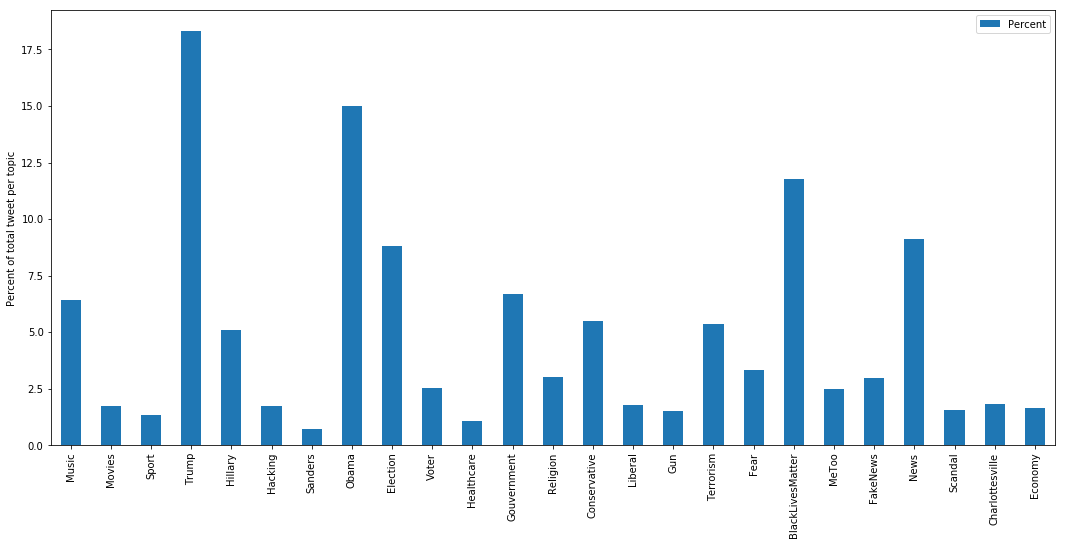

In [0]:
#plotting
ax=topic_proportion[['Percent']].plot.bar(stacked=True, figsize=(18,8))
ax.set(ylabel='Percent of total tweet per topic')
plt.show()

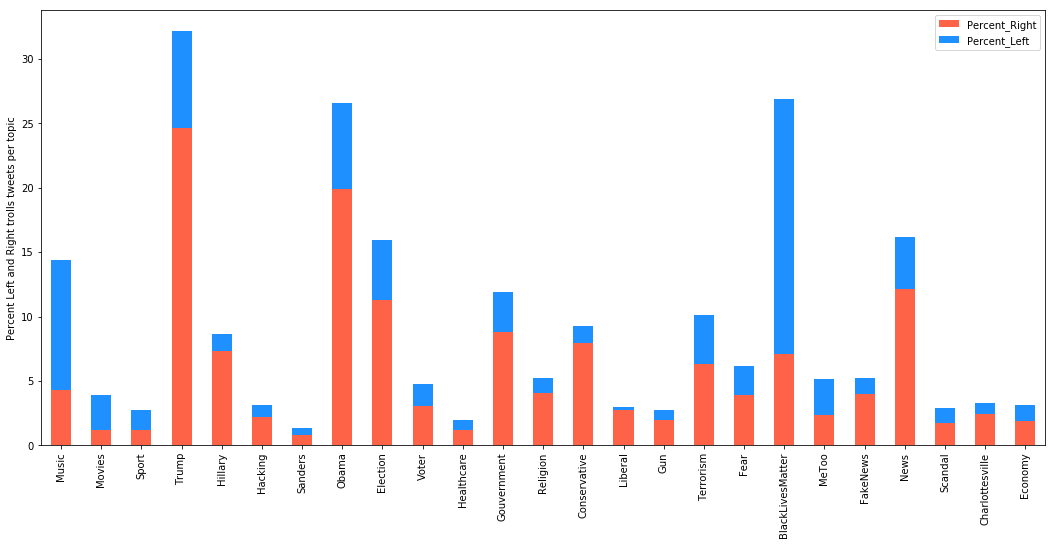

In [0]:
ax=topic_proportion[['Percent_Right','Percent_Left']].plot.bar(stacked=True, \
                                                               figsize=(18,8), color=['tomato', 'dodgerblue'])
ax.set(ylabel='Percent Left and Right trolls tweets per topic')
plt.show()

In [0]:
uncat_vocabulary=get_uncat_voc(df[df.Categorical == 0].Clean_tweet, min_count=30)

In [0]:
#uncategorized words
uncat_vocabulary.sort_values(by='Count', ascending=False).head(10).to_csv('uncat_voc.csv')

In [0]:
#how the list is extended: finds similar words
word='Beatmakers'
try:
    print('\n'.join([str(w) for w in model.wv.most_similar(stemmer.stem(word), topn=15)]))
except KeyError:
    print('Not in vocabulary or excluded during pre-processing.')

('musicproduc', 0.9106717705726624)
('sellbeat', 0.8603412508964539)
('makebeat', 0.8319610357284546)
('flstudio', 0.81572425365448)
('recordingstudio', 0.7555593252182007)
('ltltvisit', 0.6968114376068115)
('cdduplic', 0.6801841855049133)
('freebeat', 0.6778212785720825)
('homerecordingstudio', 0.6688207387924194)
('freedownload', 0.6657508015632629)
('studiolif', 0.6640921831130981)
('hiphopbeat', 0.6632857322692871)
('basecampbeat', 0.6607393622398376)
('trapbeat', 0.6445608139038086)
('macbook', 0.6418155431747437)


In [0]:
# Data Folder Names
DATA_FOLDER = './Data'
FILE_NAME_POLL = '/presidential_polls.csv'
pickle_files='Pickles/'
csv_files='Csv/'
plot_files='Plots/'

# Polls during the election

In this section, we explore the correlation between the polls score of both candidates and different variables extracted from the descriptive analysis of the tweets. The considered time is one year before the election.<br>
After, the description analysis, the trolls were characterized:
* Left trolls mainly related to BlackLiveMatters/Racial-injustice and music topic. Their aim is to divide the democratic party.
* Right trolls are pro-trump.

## Poll & Troll Tweets

### Poll Data

The Dataset contains the following columns: 
* **cycle** :   
* **branch** : 
* **type** :
* **matchup** :
* **forecastdate** : date the poll is predicting  
* **state** : in which state the poll has been conducted (U.S. mean nation wide poll)
* **startdate** : start date of poll
* **enddate** : end date of poll
* **pollster** : organism conducting the poll
* **garde** : 
* **samplesize** : number of sample in the poll
* **population** :  
* **poll_wt** : 
* **rawpoll_clinton** : poll percentage in favor of Clinton
* **rawpoll_trump** : poll percentage in favor of Trump
* **rawpoll_johnson** : poll percentage in favor of Johnson
* **rawpoll_mcmullin** : poll percentage in favor of McMullin
* **adjpoll_clinton** : ajusted poll percentage (corrected) for Clinton 
* **adjpoll_trump** : ajusted poll percentage (corrected) for Trump
* **adjpoll_johnson** : ajusted poll percentage (corrected) for Johnson
* **adjpoll_mcmullin** : ajusted poll percentage (corrected) for McMullin
* **multiversion** : 
* **url** : 
* **poll_id** : id of the poll
* **question_id** : 
* **createdate** : date of poll creation
* **timestamp** : timestamp upon data download

Import the Presidential poll data:

In [0]:
data_poll = pd.read_csv(DATA_FOLDER + FILE_NAME_POLL)
data_poll.head()

,cycle,branch,type,matchup,forecastdate,state,startdate,enddate,pollster,grade,...,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,multiversions,url,poll_id,question_id,createddate,timestamp
0,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/25/2016,10/31/2016,Google Consumer Surveys,B,...,42.64140,40.86509,5.675099,NaN,NaN,https://datastudio.google.com/u/0/#/org//repor...,47940,74999,11/1/16,15:09:38 1 Nov 2016
1,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/27/2016,10/30/2016,ABC News/Washington Post,A+,...,43.29659,44.72984,3.401513,NaN,NaN,http://www.langerresearch.com/wp-content/uploa...,47881,74936,11/1/16,15:09:38 1 Nov 2016
2,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,Virginia,10/27/2016,10/30/2016,ABC News/Washington Post,A+,...,46.29779,40.72604,6.401513,NaN,NaN,https://www.washingtonpost.com/local/virginia-...,47880,74934,11/1/16,15:09:38 1 Nov 2016
3,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,Florida,10/20/2016,10/24/2016,SurveyUSA,A,...,46.35931,45.30585,1.777730,NaN,NaN,http://www.baynews9.com/content/news/baynews9/...,47465,74252,10/25/16,15:09:38 1 Nov 2016
4,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/20/2016,10/25/2016,Pew Research Center,B+,...,45.32744,42.20888,3.618320,NaN,NaN,http://www.people-press.org/2016/10/27/as-elec...,47616,74519,10/27/16,15:09:38 1 Nov 2016


In [0]:
data_poll.describe()

,cycle,samplesize,poll_wt,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,poll_id,question_id
count,10236.0,10233.000000,10236.000000,10236.000000,10236.000000,6480.000000,51.000000,10236.000000,10236.000000,6480.000000,51.000000,10236.000000,10236.000000
mean,2016.0,1115.791557,0.221769,41.717579,39.227002,7.713394,23.235294,43.024900,42.048617,4.804207,24.877707,45317.883060,70588.462485
std,0.0,2159.610968,0.535846,7.482747,7.648679,2.948387,7.278979,6.732445,6.707382,2.492364,5.710113,2871.251404,4677.283414
min,2016.0,35.000000,0.000000,11.040000,4.000000,0.000000,9.000000,16.419590,3.233949,-3.372429,13.973230,35362.000000,47244.000000
25%,2016.0,440.000000,0.000444,38.000000,34.877500,6.000000,20.000000,40.151210,37.973375,3.321973,21.407520,44850.750000,68747.000000
50%,2016.0,772.000000,0.008206,43.000000,39.000000,7.250000,26.000000,43.732560,42.034530,4.502154,26.093830,45925.500000,71773.500000
75%,2016.0,1225.000000,0.101939,46.000000,44.000000,9.000000,29.000000,46.507035,45.373782,5.855422,29.672160,47008.250000,73497.750000
max,2016.0,40816.000000,7.591351,88.000000,68.000000,25.000000,31.000000,86.699620,71.864600,19.277800,31.982120,48000.000000,75067.000000


At first sight, the dataset seems clean. 
<br>

And we drop some useless columns:
<br>
1. We notice that `cycle` has a null std, hence the same value over all rows <br>
2. `branch` contains only the value *President*, we can thus drop it <br>
3. `matchup`contains only the value *Clinton vs Trump vs Johnson* <br>
4. We are only interested in Clinton and Trump as they are the favorites <br>
5. We don't need the url <br>
6. We can drop the `timestamp`as it is the date of when we have downloaded the dataset <br>

In [0]:
data_poll.drop(columns={'branch','cycle','matchup','rawpoll_johnson','rawpoll_mcmullin','adjpoll_johnson','adjpoll_mcmullin','url','timestamp'}, inplace=True)
data_poll.head(2)

,type,forecastdate,state,startdate,enddate,pollster,grade,samplesize,population,poll_wt,rawpoll_clinton,rawpoll_trump,adjpoll_clinton,adjpoll_trump,multiversions,poll_id,question_id,createddate
0,polls-plus,11/1/16,U.S.,10/25/2016,10/31/2016,Google Consumer Surveys,B,24316.0,lv,6.139129,37.69,35.07,42.64140,40.86509,NaN,47940,74999,11/1/16
1,polls-plus,11/1/16,U.S.,10/27/2016,10/30/2016,ABC News/Washington Post,A+,1128.0,lv,4.197292,45.00,46.00,43.29659,44.72984,NaN,47881,74936,11/1/16


We cast the `forecastdate`, `startdate`, `enddate`, and `createddate` into datetime object:

In [0]:
data_poll['forecastdate'] = pd.to_datetime(data_poll['forecastdate'])
data_poll['startdate'] = pd.to_datetime(data_poll['startdate'])
data_poll['enddate'] = pd.to_datetime(data_poll['enddate'])
data_poll['createddate'] = pd.to_datetime(data_poll['createddate'])

We use `createddate` as time reference: <br>
and we group the polls by creation dates using mean on the other columns (especially on the adjusted polls)<br>
Then a rolling mean (window of 7 days) is used to smoothed the line

In [0]:
data_poll_grp = data_poll[data_poll.state == 'U.S.'].groupby(by=['createddate']).mean()
data_poll_avg = data_poll_grp.rolling(window=7, min_periods=1).mean()

We can now plot this average adjusted polls in function of the creation date of the poll. We use Bokeh library to produce interractive plot: 

In [0]:
p = figure(plot_width=850, plot_height=450, x_axis_type='datetime')
p.title.text = 'Trump and Clinton Poll Popularity'
p.yaxis.axis_label = 'Popular Polls Rate [%]'
p.xaxis.axis_label = 'Time'

source = ColumnDataSource(data=data_poll_avg)
plot_clinton = p.line(x='createddate', y='adjpoll_clinton', source=source, legend='Clinton', color='dodgerblue',line_width=2)
plot_trump = p.line(x='createddate', y='adjpoll_trump', source=source, legend='Trump', color='tomato', line_width=2)

p.legend.click_policy = 'hide'

# Add a hover tooltip for the clinton line 
hover_tool_clinton=tools.HoverTool(
    tooltips=[
        ('Date', '@createddate{%b %d, %Y}'),
        ('Approval','@adjpoll_clinton %')],

    formatters={
        'createddate' : 'datetime', # use 'datetime' formatter for 'date' field
        'Approval' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline',
    renderers=[plot_clinton],
    attachment='above'
)

# Add a hover tooltip for the trump line 
hover_tool_trump=tools.HoverTool(
    tooltips=[
        ('Date', '@createddate{%b %d, %Y}'),
        ('Approval','@adjpoll_trump %')],

    formatters={
        'createddate' : 'datetime', # use 'datetime' formatter for 'date' field
        'Approval' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline',
    renderers=[plot_trump],
    attachment='below'
)

p.tools.append(hover_tool_clinton)
p.tools.append(hover_tool_trump)

#output_notebook()
#show(p)

In [0]:
output_file(plot_files+'Polls_timeline.html')
save(p)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/Polls_timeline.html'

The plot can be find [here](Plots/Polls_timeline.html). 

### Tweet Data

In [0]:
def get_date_time(x):
    """
    From string to datatime.date()
    input: 
        x    : str
    output:
        date : datetime - Only month/day/year
        time : datetime - Only hour/minutes/
    """
    date_time = dt.datetime.strptime(x, '%m/%d/%Y %H:%M')
    date = date_time.replace(minute=0, hour=0, second=0)
    time = date_time.hour
    
    return date


def cleaning_plot(df,dataset):
    """
    Cleans and selecting relevant tweets.
    input:
        df      - pd.DataFrame: Containing one of the IRA datasets
        dataset - int         : The IRA dataset ID
    output:
        df_tmp  - pd.DataFrame: Cleaned IRA dataset
    """
    RELEVANT_COL = ['author', 'publish_date', 'account_category', 'content', 'following', 'followers', 'retweet']
    
    #We will only select tweets in english. This represents 77% of the datasets.
    df_tmp = df[df.language == 'English'].drop(columns={'harvested_date', 'language'})
    df_tmp = df_tmp[RELEVANT_COL]

    #Keeping only right troll and left troll tweets. (57% datasets)
    df_tmp = df_tmp[(df_tmp.account_category == 'RightTroll') | (df_tmp.account_category == 'LeftTroll')  ]

    #date 
    df_tmp['publish_date'] = df_tmp.publish_date.apply(lambda x: get_date_time(x))
    df_tmp = df_tmp[df_tmp.publish_date > dt.datetime(2014,10,1,0,0,0)] #selecting after Oct 2014

    df_tmp['dataset'] = dataset #from which dataset it comes

    return df_tmp

DATA_FOLDER = 'Data/'
TWEET_DATA = 'russian-troll-tweets/IRAhandle_tweets_'
APPROVAL_DATA = 'approval_polllist.csv'
CAMPAIGN_POLLS = 'presidential_polls.csv'

tweet_data = pd.DataFrame()

# The dataset is composed of 9 sub_datasets
for dataset in range(1,9):
    df_tmp = cleaning_plot(pd.read_csv(DATA_FOLDER + TWEET_DATA + str(dataset) + '.csv'), dataset)
    tweet_data = tweet_data.append(df_tmp, ignore_index=True)

Plot the tweet number and the average polls in a vertical subplot

In [0]:
# x-axis boundaries 
start_date = dt.datetime(2016,3,1,0,0,0)
end_date = dt.datetime(2016,11,8,0,0,0)

# Poll Plot
top_plot = figure(plot_width=850, plot_height=450, x_axis_type='datetime', x_range=(start_date, end_date))
top_plot.title.text = 'Trump and Clinton Poll Popularity'
top_plot.yaxis.axis_label = 'Popular Polls Rate [%]'
top_plot.xaxis.axis_label = 'Time'

source = ColumnDataSource(data=data_poll_avg)
plot_clinton = top_plot.line(x='createddate', y='adjpoll_clinton', source=source, legend='Clinton', color='dodgerblue',line_width=2)
plot_trump = top_plot.line(x='createddate', y='adjpoll_trump', source=source, legend='Trump', color='tomato', line_width=2)

top_plot.legend.click_policy = 'hide'

# Hover tooltip object for clinton line
hover_tool_clinton=tools.HoverTool(
    tooltips=[
        ('Date', '@createddate{%b %d, %Y}'),
        ('Approval','@adjpoll_clinton %')],

    formatters={
        'createddate' : 'datetime', # use 'datetime' formatter for 'date' field
        'Approval' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline',
    renderers=[plot_clinton],
    attachment='above'
)

# Hover tooltip object for trump line 
hover_tool_trump=tools.HoverTool(
    tooltips=[
        ('Date', '@createddate{%b %d, %Y}'),
        ('Approval','@adjpoll_trump %')],

    formatters={
        'createddate' : 'datetime', # use 'datetime' formatter for 'date' field
        'Approval' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline',
    renderers=[plot_trump],
    attachment='below'
)

top_plot.tools.append(hover_tool_clinton)
top_plot.tools.append(hover_tool_trump)

# Tweet plot 
bottom_plot = figure(plot_width=850, plot_height=450, x_axis_type='datetime', x_range=(start_date, end_date))
bottom_plot.title.text = 'Tweeting activity according to Right and Left category'
bottom_plot.yaxis.axis_label = 'Tweet density'

categories=tweet_data.account_category.unique()
colorplot = ['tomato','dodgerblue']

for color, category in enumerate(categories):
    df_plot = pd.DataFrame(tweet_data[tweet_data.account_category==category].publish_date.value_counts().sort_index())
    source = ColumnDataSource(data=df_plot)
    bottom_plot.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend=category, color=colorplot[color])

bottom_plot.legend.location = 'top_left'
bottom_plot.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%b %d, %Y}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline'
)

bottom_plot.tools.append(hover_tool)

#output_notebook()

p2 = gridplot([[top_plot] , [bottom_plot]])

#show(p2)

In [0]:
output_file(plot_files+'Polls_Tweets.html')
save(p2)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/Polls_Tweets.html'

The above plot ([see here](Plots/Polls_Tweets.html)) does not seems to show any clear qualitative correlation between the Russian troll tweet number and the polls results for either Clinton or Trump. In consequence we will look at the right/left troll tweet number in function of the average clinton/trump polls rate, and see if any dependancy pattern appears. 

We first get the number of right/left troll tweets per days

In [0]:
tweet_data_right = tweet_data[tweet_data['account_category'] == 'RightTroll'] 
tweet_data_left = tweet_data[tweet_data['account_category'] == 'LeftTroll']
tweet_count = pd.DataFrame({'RightTroll count':tweet_data_right.publish_date.value_counts().sort_index(), \
                            'LeftTroll count':tweet_data_left.publish_date.value_counts().sort_index()}).fillna(0)
tweet_count.head()

,RightTroll count,LeftTroll count
2014-10-18,0.0,1.0
2014-11-25,26.0,0.0
2014-11-26,35.0,0.0
2014-11-28,82.0,0.0
2014-12-01,12.0,0.0


We then merge the polls averages with the troll tweets numbers based on the startdate of the polls and the tweet's dates:

In [0]:
# group by polls start dates 
data_poll_grp = data_poll[data_poll.state == 'U.S.'].groupby(by=['startdate']).mean()
# smoothen the data with a rolling mean over a week 
data_poll_avg = data_poll_grp.rolling(window=7, min_periods=1).mean()
# merge by date data with right and left troll counts
data_tweet_polls = data_poll_avg[['adjpoll_clinton','adjpoll_trump']].merge(tweet_count, left_index=True, right_index=True)
data_tweet_polls.head(2)

,adjpoll_clinton,adjpoll_trump,RightTroll count,LeftTroll count
2015-11-13,44.955033,44.399360,309.0,24.0
2015-11-15,47.463690,42.957813,3088.0,179.0


We can now plot : <br>
* clinton poll vs right trolls tweet count
* clinton poll vs left trolls tweet count
* trump poll vs right trolls tweet count
* trump poll vs left trolls tweet count

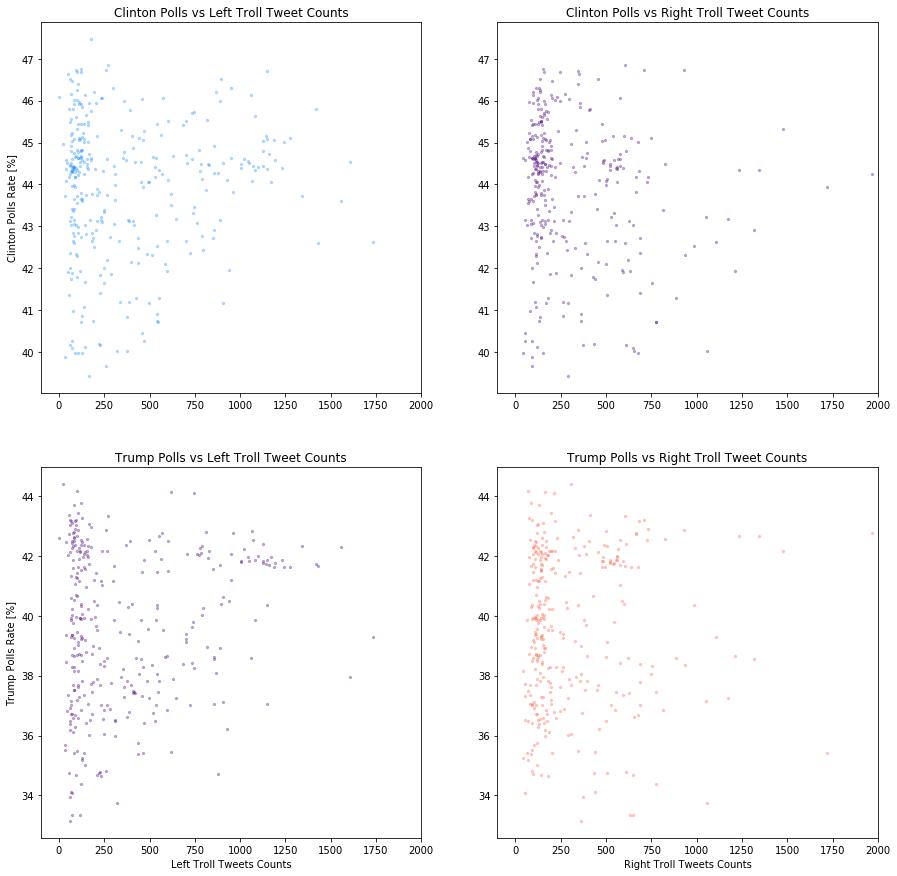

In [0]:
figTweetPolls = plt.figure(figsize=(15,15))

ax1 = figTweetPolls.add_subplot(2,2,1)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='adjpoll_clinton', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Clinton Polls vs Left Troll Tweet Counts')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Clinton Polls Rate [%]')
ax1.set_xlim(-100,2000)

ax2 = figTweetPolls.add_subplot(2,2,2)
data_tweet_polls.plot.scatter(x='RightTroll count', y='adjpoll_clinton', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Clinton Polls vs Right Troll Tweet Counts')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
ax2.set_xlim(-100,2000)

ax3 = figTweetPolls.add_subplot(2,2,3)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='adjpoll_trump', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Trump Polls vs Left Troll Tweet Counts')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Trump Polls Rate [%]')
ax3.set_xlim(-100,2000)

ax4 = figTweetPolls.add_subplot(2,2,4)
data_tweet_polls.plot.scatter(x='RightTroll count', y='adjpoll_trump', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Trump Polls vs Right Troll Tweet Counts')
ax4.set_xlabel('Right Troll Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
ax4.set_xlim(-100,2000)

plt.show()

In [0]:
data_tweet_polls.corr('spearman')

,adjpoll_clinton,adjpoll_trump,RightTroll count,LeftTroll count
adjpoll_clinton,1.000000,0.378848,-0.087815,0.012457
adjpoll_trump,0.378848,1.000000,0.111922,0.070247
RightTroll count,-0.087815,0.111922,1.000000,0.139167
LeftTroll count,0.012457,0.070247,0.139167,1.000000


As visible in the above plot and the corresponding pearson coefficient, there are no clear correlation between number of troll tweets and the polls rate. <br>
However we cannot expect the troll tweet to chnage the polls drastically up to the percent changes. There are many more factors playing in the poll than just the troll tweets. In consequences, we will look at the polls variation over time and look whether it correltate with troll activity on twitter. To do so we compute the derivative of the polls rate with respect to time:  

In [0]:
#get the derivative with respect to time for the Clinton and Trump Polls 
data_tweet_polls[['dpolls_clinton', 'dpolls_trump']] = data_tweet_polls[['adjpoll_clinton','adjpoll_trump']].diff()
data_tweet_polls['time_diff'] = data_tweet_polls.index.to_series().diff().dt.days
data_tweet_polls['dpolls_clinton/dt'] = data_tweet_polls['dpolls_clinton']/data_tweet_polls['time_diff']
data_tweet_polls['dpolls_trump/dt'] = data_tweet_polls['dpolls_trump']/data_tweet_polls['time_diff']
data_tweet_polls.head(2)

,adjpoll_clinton,adjpoll_trump,RightTroll count,LeftTroll count,dpolls_clinton,dpolls_trump,time_diff,dpolls_clinton/dt,dpolls_trump/dt
2015-11-13,44.955033,44.399360,309.0,24.0,NaN,NaN,NaN,NaN,NaN
2015-11-15,47.463690,42.957813,3088.0,179.0,2.508657,-1.441547,2.0,1.254328,-0.720773


We can now visualize how the polls variation changes with the troll tweets counts : 

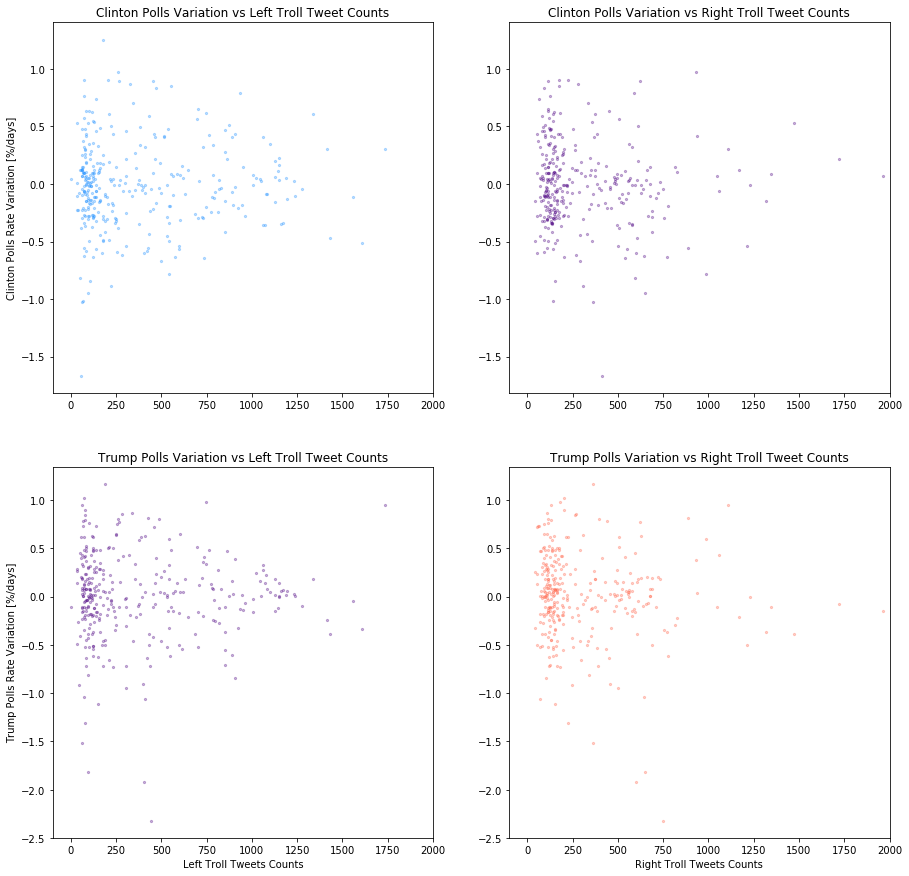

In [0]:
figTweetVarPolls = plt.figure(figsize=(15,15))

ax1 = figTweetVarPolls.add_subplot(2,2,1)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='dpolls_clinton/dt', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Clinton Polls Variation vs Left Troll Tweet Counts')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Clinton Polls Rate Variation [%/days]')
ax1.set_xlim(-100,2000)

ax2 = figTweetVarPolls.add_subplot(2,2,2)
data_tweet_polls.plot.scatter(x='RightTroll count', y='dpolls_clinton/dt', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Clinton Polls Variation vs Right Troll Tweet Counts')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
ax2.set_xlim(-100,2000)

ax3 = figTweetVarPolls.add_subplot(2,2,3)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='dpolls_trump/dt', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Trump Polls Variation vs Left Troll Tweet Counts')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Trump Polls Rate Variation [%/days]')
ax3.set_xlim(-100,2000)

ax4 = figTweetVarPolls.add_subplot(2,2,4)
data_tweet_polls.plot.scatter(x='RightTroll count', y='dpolls_trump/dt', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Trump Polls Variation vs Right Troll Tweet Counts')
ax4.set_xlabel('Right Troll Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
ax4.set_xlim(-100,2000)

plt.show()

Here is another way of looking (qualitatively) at it : 

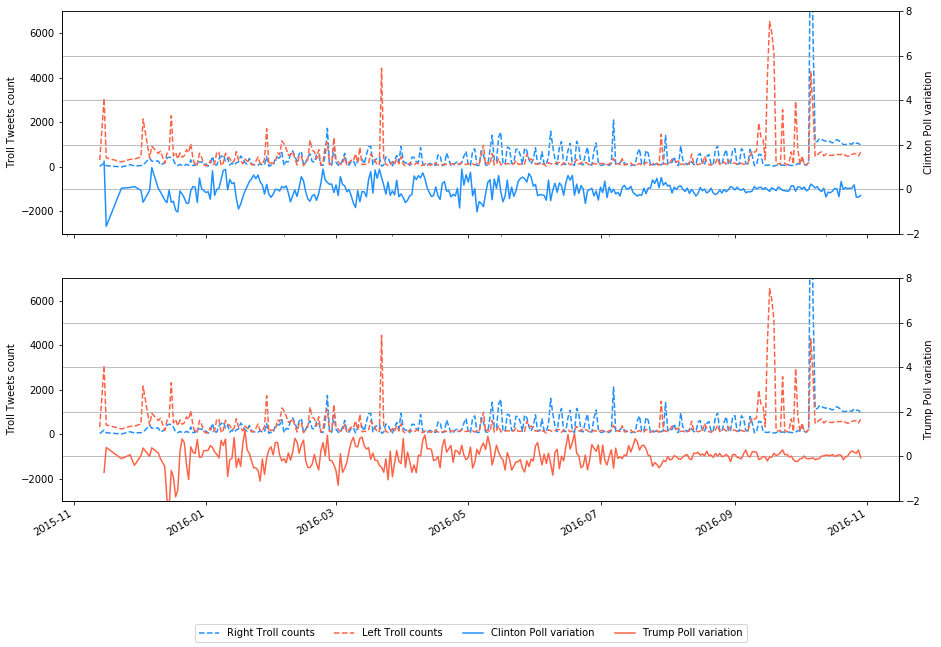

In [0]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax1_2 = ax1.twinx()
data_tweet_polls.loc[:,['LeftTroll count','RightTroll count']].plot(ax=ax1, color=['dodgerblue','tomato'], linestyle='--')
data_tweet_polls.loc[:,['dpolls_clinton/dt']].plot(ax=ax1_2, color='dodgerblue')
ax1_2.set_ylim(-2,8)
ax1.set_ylim(-3000,7000)
ax1_2.grid(True)
ax1.set_ylabel('Troll Tweets count')
ax1_2.set_ylabel('Clinton Poll variation')

ax2 = fig.add_subplot(212)
ax2_2 = ax2.twinx()
data_tweet_polls.loc[:,['LeftTroll count','RightTroll count']].plot(ax=ax2, color=['dodgerblue','tomato'], linestyle='--')
data_tweet_polls.loc[:,['dpolls_trump/dt']].plot(ax=ax2_2, color='tomato')
ax2_2.set_ylim(-2,8)
ax2.set_ylim(-3000,7000)
ax2_2.grid(True)
ax2.set_ylabel('Troll Tweets count')
ax2_2.set_ylabel('Trump Poll variation')

ax1.legend().remove()
ax1_2.legend().remove()
ax2.legend().remove()
ax2_2.legend().remove()

fig.legend((ax1.get_lines()[0],ax1.get_lines()[1],ax1_2.get_lines()[0],ax2_2.get_lines()[0]),\
           ('Right Troll counts','Left Troll counts','Clinton Poll variation','Trump Poll variation'),\
           loc = 'lower center', ncol=4 )

plt.show()

In [0]:
data_tweet_polls[['RightTroll count','LeftTroll count','dpolls_clinton/dt','dpolls_trump/dt']].corr(method='spearman')

,RightTroll count,LeftTroll count,dpolls_clinton/dt,dpolls_trump/dt
RightTroll count,1.000000,0.139167,-0.042127,-0.135943
LeftTroll count,0.139167,1.000000,0.016110,-0.059385
dpolls_clinton/dt,-0.042127,0.016110,1.000000,-0.049331
dpolls_trump/dt,-0.135943,-0.059385,-0.049331,1.000000


Even here, it does not seems that the number of troll tweets correlate with the polls variations. We should look for other variables that may correlate with the polls: we'll start by looking at the number of person directly touched by the tweets (*i.e.* the number of followers). 

We get how many people (the maximum people) are reached everyday by right and left trolls respectively:

In [0]:
people=tweet_data[['publish_date', 'account_category','followers', 'author']]\
            .groupby(by=['publish_date', 'account_category', 'author']).max()\
            .unstack('account_category').fillna(0)\
            .groupby('publish_date').sum()
people.followers.head()

account_category,LeftTroll,RightTroll
publish_date,,
2014-10-18,6.0,0.0
2014-11-25,0.0,84.0
2014-11-26,0.0,84.0
2014-11-28,0.0,84.0
2014-12-01,0.0,98.0


In [0]:
len(people)

1256

In [0]:
test = people.followers.sample(n=45, random_state=1)
test = test.interpolate(method='time', order=5)
test.sort_index(inplace=True)
test.head()

account_category,LeftTroll,RightTroll
publish_date,,
2015-02-19,0.0,7598.0
2015-04-02,0.0,18222.0
2015-04-03,0.0,18173.0
2015-04-14,615.0,27065.0
2015-05-07,83.0,24954.0


In [0]:
plot_df = people.followers.sample(n=45, random_state=1)
plot_df = test.interpolate(method='time', order=5).sort_index()

p3 = figure(plot_width=950, plot_height=450, x_axis_type='datetime')
p3.title.text = 'Maximal People directly reached by the tweets'
p3.yaxis.axis_label = 'Tweet density'

source = ColumnDataSource(data=plot_df)
left=p3.line(x='publish_date', y='LeftTroll', line_width=2, alpha=1, legend='Left', color='dodgerblue', source=source)

source = ColumnDataSource(data=plot_df)
right=p3.line(x='publish_date', y='RightTroll', line_width=2, alpha=1, legend='Right', color='tomato', source=source)
p3.legend.location = 'top_left'
p3.legend.click_policy='hide'

hover_tool_R=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%F}'),
        ('People reached','@RightTroll')],
    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'RightTroll' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    mode='vline',
    renderers=[right],
    attachment='above'
)

hover_tool_L=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%F}'),
        ('People reached','@LeftTroll')],
    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'LeftTrollTroll' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    mode='vline',
    renderers=[left],
    attachment='below'
)

p3.tools.append(hover_tool_R)
p3.tools.append(hover_tool_L)

#output_notebook()
#follower_plot = gridplot([[p3],[p4]])

In [0]:
#show(follower_plot)
output_file(plot_files+'People_Reached.html')
save(p3)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/People_Reached.html'

In [0]:
p4 = figure(plot_width=950, plot_height=450, x_axis_type='datetime')
p4.title.text = 'Tweeting activity according to Right and Left category'
p4.yaxis.axis_label = 'Tweet density'

categories=tweet_data.account_category.unique()
colorplot = ['tomato','dodgerblue']

for color, category in enumerate(categories):
    df_plot = pd.DataFrame(tweet_data[tweet_data.account_category==category].publish_date.value_counts().sort_index())
    source = ColumnDataSource(data=df_plot)
    p4.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend=category, color=colorplot[color])

p4.legend.location = 'top_left'
p4.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%b %d, %Y}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline', 
    renderers=[right],
    attachment='below'
)

p4.tools.append(hover_tool)

In [0]:
output_file(plot_files+'Tweet_Activity.html')
save(p4)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/Tweet_Activity.html'

The plot can be observed [here](Plots/Follower_Plot.html)

In [0]:
data_follower_polls = data_poll_avg[['adjpoll_clinton','adjpoll_trump']].merge(people.followers, left_index=True, right_index=True)
data_follower_polls.head(2)

,adjpoll_clinton,adjpoll_trump,LeftTroll,RightTroll
2015-11-13,44.955033,44.399360,5514.0,60626.0
2015-11-15,47.463690,42.957813,14882.0,87626.0


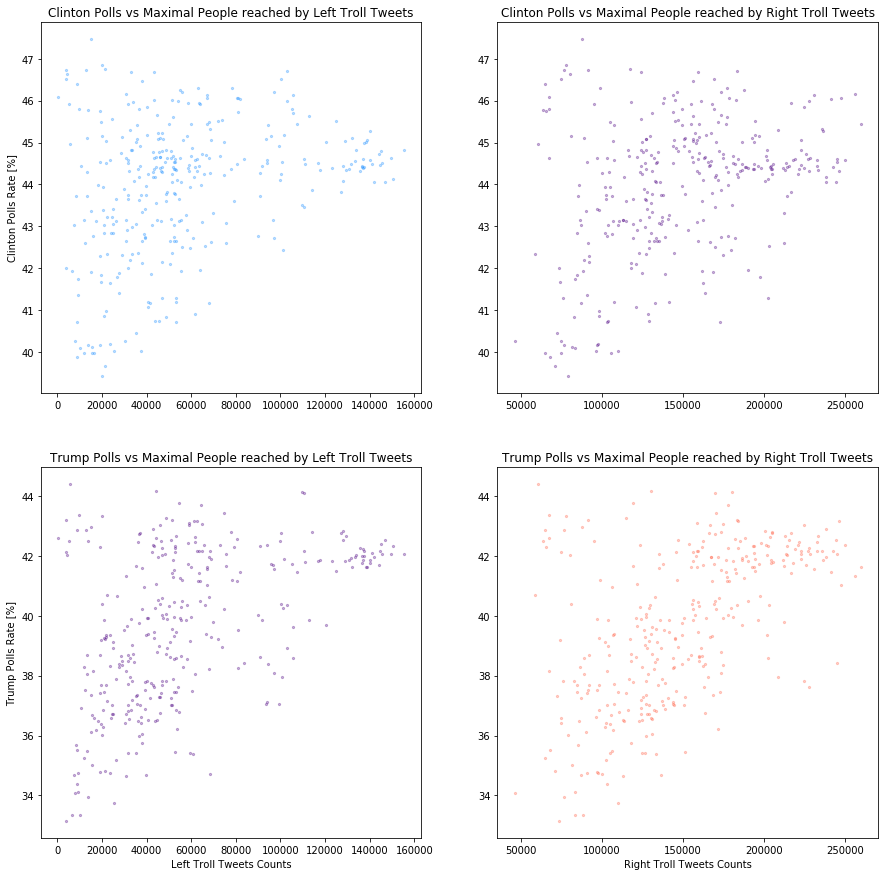

In [0]:
figFollowerPolls = plt.figure(figsize=(15,15))

ax1 = figFollowerPolls.add_subplot(2,2,1)
data_follower_polls.plot.scatter(x='LeftTroll', y='adjpoll_clinton', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Clinton Polls vs Maximal People reached by Left Troll Tweets')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Clinton Polls Rate [%]')
#ax1.set_xlim(-100,2000)

ax2 = figFollowerPolls.add_subplot(2,2,2)
data_follower_polls.plot.scatter(x='RightTroll', y='adjpoll_clinton', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Clinton Polls vs Maximal People reached by Right Troll Tweets')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
#ax2.set_xlim(-100,2000)

ax3 = figFollowerPolls.add_subplot(2,2,3)
data_follower_polls.plot.scatter(x='LeftTroll', y='adjpoll_trump', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Trump Polls vs Maximal People reached by Left Troll Tweets')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Trump Polls Rate [%]')
#ax3.set_xlim(-100,2000)

ax4 = figFollowerPolls.add_subplot(2,2,4)
data_follower_polls.plot.scatter(x='RightTroll', y='adjpoll_trump', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Trump Polls vs Maximal People reached by Right Troll Tweets')
ax4.set_xlabel('Right Troll Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
#ax4.set_xlim(-100,2000)

plt.show()

In [0]:
data_follower_polls.corr(method='spearman')

,adjpoll_clinton,adjpoll_trump,LeftTroll,RightTroll
adjpoll_clinton,1.000000,0.378848,0.272572,0.303192
adjpoll_trump,0.378848,1.000000,0.478387,0.544046
LeftTroll,0.272572,0.478387,1.000000,0.729874
RightTroll,0.303192,0.544046,0.729874,1.000000


Using the maximal number of followers as variable seems to yield a better correlation. It's still too low to be relvant though. It also seems that the number of people touched by tweets is more related to Trump's polls rate. 

In [0]:
data_follower_dpolls = data_follower_polls.merge(data_tweet_polls[['dpolls_clinton/dt','dpolls_trump/dt']], right_index=True, left_index=True)
data_follower_dpolls.head()

,adjpoll_clinton,adjpoll_trump,LeftTroll,RightTroll,dpolls_clinton/dt,dpolls_trump/dt
2015-11-13,44.955033,44.399360,5514.0,60626.0,NaN,NaN
2015-11-15,47.463690,42.957813,14882.0,87626.0,1.254328,-0.720773
2015-11-16,45.797366,43.352058,9813.0,67137.0,-1.666324,0.394245
2015-11-23,46.094291,42.585376,363.0,67592.0,0.042418,-0.109526
2015-11-27,46.409250,42.859774,9048.0,64735.0,0.078740,0.068599


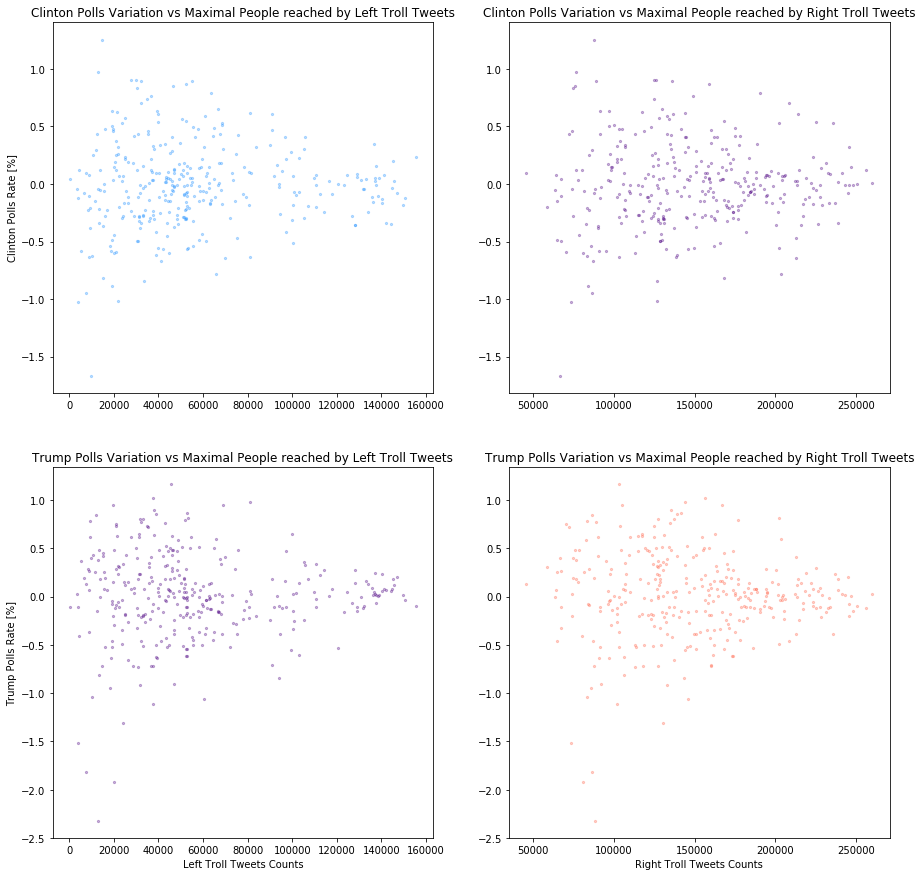

In [0]:
figFollower_dPolls = plt.figure(figsize=(15,15))

ax1 = figFollower_dPolls.add_subplot(2,2,1)
data_follower_dpolls.plot.scatter(x='LeftTroll', y='dpolls_clinton/dt', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Clinton Polls Variation vs Maximal People reached by Left Troll Tweets')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Clinton Polls Rate [%]')
#ax1.set_xlim(-100,2000)

ax2 = figFollower_dPolls.add_subplot(2,2,2)
data_follower_dpolls.plot.scatter(x='RightTroll', y='dpolls_clinton/dt', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Clinton Polls Variation vs Maximal People reached by Right Troll Tweets')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
#ax2.set_xlim(-100,2000)

ax3 = figFollower_dPolls.add_subplot(2,2,3)
data_follower_dpolls.plot.scatter(x='LeftTroll', y='dpolls_trump/dt', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Trump Polls Variation vs Maximal People reached by Left Troll Tweets')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Trump Polls Rate [%]')
#ax3.set_xlim(-100,2000)

ax4 = figFollower_dPolls.add_subplot(2,2,4)
data_follower_dpolls.plot.scatter(x='RightTroll', y='dpolls_trump/dt', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Trump Polls Variation vs Maximal People reached by Right Troll Tweets')
ax4.set_xlabel('Right Troll Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
#ax4.set_xlim(-100,2000)

plt.show()

In [0]:
data_follower_dpolls.corr(method='spearman')

,adjpoll_clinton,adjpoll_trump,LeftTroll,RightTroll,dpolls_clinton/dt,dpolls_trump/dt
adjpoll_clinton,1.000000,0.378848,0.272572,0.303192,0.113826,-0.078330
adjpoll_trump,0.378848,1.000000,0.478387,0.544046,0.070262,0.036928
LeftTroll,0.272572,0.478387,1.000000,0.729874,0.052898,-0.048336
RightTroll,0.303192,0.544046,0.729874,1.000000,0.039261,-0.068736
dpolls_clinton/dt,0.113826,0.070262,0.052898,0.039261,1.000000,-0.049331
dpolls_trump/dt,-0.078330,0.036928,-0.048336,-0.068736,-0.049331,1.000000


## Topic correlation

We now examine the potential correlation between the polls and the topics. The topics were previously defined in the `WebScrap.ipynb`. The number of tweet per day for each topic is compared with the approval score for each candidate.

In [0]:
def load_topic_df(filename=pickle_files +'topic_df.plk'):
    """Load the pickle generated in the WebScrap.ipynb
    Contains: the tweet content, the publish_data, the topics"""
    with open(filename, 'rb') as df_top:
            df_topic=pickle.load(df_top) 
        
    print("Df topic loaded <---")
    
    return df_topic        

In [0]:
#loading data
df_topic=load_topic_df()
df_topic.columns

Df topic loaded <---


Index(['publish_date', 'content', 'account_category', 'Clean_tweet',
       'hashtags', 'Mentioned', 'Music', 'Movies', 'Sport', 'Trump', 'Hillary',
       'Hacking', 'Sanders', 'Obama', 'Election', 'Voter', 'Healthcare',
       'Gouvernment', 'Religion', 'Conservative', 'Liberal', 'Gun',
       'Terrorism', 'Fear', 'BlackLivesMatter', 'MeToo', 'FakeNews', 'News',
       'Scandal', 'Charlottesville', 'Economy', 'Categorical'],
      dtype='object')

In [0]:
#selecting relevant columns
df_topic=df_topic.drop(columns={'content', 'Clean_tweet', 'hashtags','Categorical', 'Charlottesville'})
print('\nThe {} topics are:\n    {}'.format(len(df_topic.columns[2:]), '\n    '.join([topic for topic in df_topic.columns[2:].tolist()])))


The 25 topics are:
    Mentioned
    Music
    Movies
    Sport
    Trump
    Hillary
    Hacking
    Sanders
    Obama
    Election
    Voter
    Healthcare
    Gouvernment
    Religion
    Conservative
    Liberal
    Gun
    Terrorism
    Fear
    BlackLivesMatter
    MeToo
    FakeNews
    News
    Scandal
    Economy


In [0]:
df_poll_topic= data_poll_avg.drop(columns={'samplesize', 'poll_wt', 'rawpoll_clinton', 'rawpoll_trump', 'poll_id', 'question_id'})

#Get the count of tweet per day for each category
df_topic=df_topic.groupby(by=['account_category','publish_date']).sum().unstack("account_category").fillna(0)

Merging the polls data and the topic tweet count per day.

In [0]:
df_scatter=df_poll_topic.merge(df_topic, how='inner', right_index=True, left_index=True)

#Renaming columns
df_scatter.columns= df_scatter.columns[:2].tolist()+ [t[0]+'_'+t[1] for t in df_scatter.columns.tolist()[2:]]

/Users/nicolasgandar/anaconda3/envs/ada/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


**Plotting and Correlation computing**

The Spearman correlation coefficient is computed.

In [0]:
p_cl = figure(plot_width=800, plot_height=600, y_range=(0,1000))
p_cr=figure(plot_width=800, plot_height=600, y_range=(0,1000))

p_tr=figure(plot_width=800, plot_height=600, y_range=(0,1000))
p_tl = figure(plot_width=800, plot_height=600, y_range=(0,1000))


colors = ['darkolivegreen', 'darkmagenta','tomato', 'dodgerblue', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkolivegreen']
source=ColumnDataSource(data=df_scatter)

df_corr=pd.DataFrame()

for color, topic in enumerate(df_topic.columns.levels[0]):
    
    #correlation
    df_corr.loc[topic,'Cl']=df_scatter.loc[:, [topic+'_LeftTroll', 'adjpoll_clinton']].corr(method='spearman').values.flatten()[1]
    df_corr.loc[topic,'Tl']=df_scatter.loc[:, [topic+'_LeftTroll', 'adjpoll_trump']].corr(method='spearman').values.flatten()[1]
    df_corr.loc[topic,'Tr']=df_scatter.loc[:, [topic+'_RightTroll', 'adjpoll_trump']].corr(method='spearman').values.flatten()[1]
    df_corr.loc[topic,'Cr']=df_scatter.loc[:, [topic+'_RightTroll', 'adjpoll_clinton']].corr(method='spearman').values.flatten()[1]
    
    #plotting
    p_cl.scatter(x='adjpoll_clinton', y=topic+'_LeftTroll', source=source, legend=topic, color=colors[color])
    p_cl.yaxis.axis_label = 'LeftTroll'
    p_cl.xaxis.axis_label='Clinton'
    
   
    p_cr.scatter(x='adjpoll_clinton', y=topic+'_RightTroll', source=source, legend=topic, color=colors[color])
    p_cr.yaxis.axis_label = 'RightTroll'
    p_cr.xaxis.axis_label='Clinton'
    
    p_tl.scatter(x='adjpoll_trump', y=topic+'_LeftTroll', source=source, legend=topic, color=colors[color])
    p_tl.yaxis.axis_label = 'LeftTroll'
    p_tl.xaxis.axis_label='Trump'
    
    
    p_tr.scatter(x='adjpoll_trump', y=topic+'_RightTroll', source=source, legend=topic, color=colors[color])
    p_tr.yaxis.axis_label = 'RightTroll'
    p_tr.xaxis.axis_label='Trump'
    
    p_cl.legend.click_policy='hide'
    p_cr.legend.click_policy='hide'
    p_tl.legend.click_policy='hide'
    p_tr.legend.click_policy='hide'
    

p_tr.legend.location = 'top_left'
p_tr.legend.orientation = "vertical"
p_tr.legend.label_text_font_size="12pt"

p_tl.legend.location = 'top_left'
p_tl.legend.orientation = "vertical"
p_tl.legend.label_text_font_size="12pt"

p_cr.legend.location = 'top_left'
p_cr.legend.orientation = "vertical"
p_cr.legend.label_text_font_size="12pt"


p_cl.legend.location = 'top_left'
p_cl.legend.orientation = "vertical"
p_cl.legend.label_text_font_size="12pt"

grid=column([p_cl, p_cr, p_tr, p_tl])
#output_notebook()

In [0]:
output_file(plot_files+'Polls_Topic.html')
save(grid)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/Polls_Topic.html'

The plot can be find [here](Plots/Polls_Topic.html). 

In [0]:
#show(grid)

In [0]:
df_corr.index.name='topic'
df_corr.to_csv(csv_files+'Correlation_topic.csv')
df_corr

,Cl,Tl,Tr,Cr
topic,,,,
Music,0.006275,0.079892,0.042881,-0.101534
Movies,0.035022,0.193500,0.115236,0.003084
Sport,0.034505,0.154744,0.159484,0.007114
Trump,-0.008614,0.047620,0.231547,-0.053900
Hillary,0.084173,0.030226,0.416107,0.137224
Hacking,0.108722,0.150691,0.425705,0.156624
Sanders,-0.250026,-0.296947,-0.317572,-0.189376
Obama,0.004486,0.119540,0.040116,-0.082161
Election,-0.050593,-0.020193,0.162942,-0.120399


Saving to csv.

In [0]:
df_scatter.index.name='date'
df_scatter.to_csv(csv_files+'Scatter_Polls_Topics_Elections.csv')

In [0]:
DATA_FOLDER = 'Data/'
TWEET_DATA = 'russian-troll-tweets/IRAhandle_tweets_'
APPROVAL_DATA = 'approval_polllist.csv'
APPROVAL_POLLLIST = 'approval_polllist.csv'
CAMPAIGN_POLLS = 'presidential_polls.csv'
plot_files='Plots/'
pickle_files='Pickles/'
csv_files='Csv/'

# Trump's presidency approvals

This notebook focuses on the analysis of Trump's approval rating and introduces a "key hashtags" dataframe useful to understanding the causes behind the tweet peaks.

## Data Loading

### Tweets data

In [0]:
def get_date_time(x):
    """
    From string to datatime.date()
    input: 
        x    : str
    output:
        date : datetime - Only month/day/year
        time : datetime - Only hour/minutes/
    """
    date_time = dt.datetime.strptime(x, '%m/%d/%Y %H:%M')
    #print(date_time)
    date = date_time.replace(minute=0, hour=0, second=0)
    #print(date)
    time = date_time.hour
    #type(time)
    
    return date


def cleaning_plot(df,dataset):
    """
    Cleans and selecting relevant tweets.
    input:
        df      - pd.DataFrame: Containing one of the IRA datasets
        dataset - int         : The IRA dataset ID
    output:
        df_tmp  - pd.DataFrame: Cleaned IRA dataset
    """
    RELEVANT_COL = ['author', 'publish_date', 'account_category', 'content', 'following', 'followers', 'retweet']
    
    #We will only select tweets in english. This represents 77% of the datasets.
    df_tmp = df[df.language == 'English'].drop(columns={'harvested_date', 'language'})
    df_tmp = df_tmp[RELEVANT_COL]

    #Keeping only right troll and left troll tweets. (57% datasets)
    df_tmp = df_tmp[(df_tmp.account_category == 'RightTroll') | (df_tmp.account_category == 'LeftTroll')  ]

    #date 
    df_tmp['publish_date'] = df_tmp.publish_date.apply(lambda x: get_date_time(x))
    df_tmp = df_tmp[df_tmp.publish_date > dt.datetime(2014,10,1,0,0,0)] #selecting after Oct 2014

    df_tmp['dataset'] = dataset #from which dataset it comes

    return df_tmp

Loading data from the tweets

In [0]:
tweet_data = pd.DataFrame()

# The dataset is composed of 9 sub_datasets
for dataset in range(1,9):
    df_tmp = cleaning_plot(pd.read_csv(DATA_FOLDER + TWEET_DATA + str(dataset) + '.csv'), dataset)
    tweet_data = tweet_data.append(df_tmp, ignore_index=True)

### Polls data

In [0]:
df = pd.read_csv(DATA_FOLDER + APPROVAL_DATA)
#Selecting only relevant columns for approval data
UNRELEVANT = ['president', 'modeldate', 'createddate', 'enddate', 'url',\
              'question_id', 'tracking', 'multiversions', 'timestamp']
approval_df = df.drop(columns=UNRELEVANT)

#keeping only good pollster
#GOOD_GRADES = ['A+', 'A', 'A-', 'B+']
#approval_df = approval_df[approval_df.grade.isin(GOOD_GRADES)]


#Datetime format
approval_df.startdate = approval_df.apply(lambda row: datetime.strptime(row['startdate'], "%m/%d/%Y"),\
                                            axis=1)
approval_df.sort_values(by=['startdate'], inplace=True)
approval_df.reset_index(drop=True, inplace=True)
approval_df.head()

,subgroup,startdate,pollster,grade,samplesize,population,weight,influence,approve,disapprove,adjusted_approve,adjusted_disapprove,poll_id
0,All polls,2017-01-20,Morning Consult,B-,1992.0,rv,0.946437,0.0,46.0,37.0,42.97840,39.17828,49249
1,Adults,2017-01-20,Ipsos,B+,1632.0,a,0.224456,0.0,42.1,45.2,41.68539,44.23673,49426
2,Voters,2017-01-20,Morning Consult,B-,1992.0,rv,0.946437,0.0,46.0,37.0,44.03498,38.65438,49249
3,Voters,2017-01-20,Ipsos,B+,509.0,lv,0.127926,0.0,45.2,44.3,44.95828,42.77118,49426
4,Voters,2017-01-20,Quinnipiac University,A-,1190.0,rv,1.644662,0.0,36.0,44.0,38.64014,42.18154,49260


In [0]:
#We looked for events corresponding to increased tweet density
events_date = ["2015-07-21", "2015-11-15", "2015-11-15", "2016-03-22", 
               "2016-09-16", "2016-09-26", "2016-09-27", "2016-10-04", 
               "2016-10-06", "2016-10-07", "2016-10-07", "2016-10-07",
               "2016-11-08", "2016-11-09", "2017-07-24", "2017-07-31", 
               "2017-08-03", "2017-08-08", "2017-08-11"]
events_list = ["Chattanooga shootings", "Democrate Debate", 
               "Jamar Clark was shot by Minneapolis Police Department - BlackLivesMatter", 
               "Brussels Bombings", "CNN releases poll of polls: Hillary ahead by 2 points", 
               "Presidential Debate", "Alfredo Olango Police shooting - Blacklivesmatter", 
               "VP debate","Istanbul bombings", "Grab her by the pussy", "Obama admin. says Russia hacked DNC", 
               "Wikileaks releases Clinton emails", "Election Day", "Trump Elected", "Imran Awan scandal", 
               "Charlie Baker, GOP Gov is reelected as Massachusset gov", 
               "Leaked telephone conversations between Donald Trump and foreign leaders are leaked. ", 
               "North Korea Crisis", "Charlottesville riot"]
events_cat = ["RightTroll", "RightTroll", "LeftTroll", 
              "RightTroll", "RightTroll", "RightTroll", 
              "LeftTroll", "RightTroll", "RightTroll", 
              "LeftTroll", "RightTroll","LeftTroll", 
              "Both", "RightTroll", "RightTroll", 
              "RightTroll", "RightTroll", "RightTroll", "RightTroll"]
events_df = pd.DataFrame()
events_df['Dates'] = events_date
events_df['Events'] = events_list
events_df['Category'] = events_cat
events_df.head()

,Dates,Events,Category
0,2015-07-21,Chattanooga shootings,RightTroll
1,2015-11-15,Democrate Debate,RightTroll
2,2015-11-15,Jamar Clark was shot by Minneapolis Police Dep...,LeftTroll
3,2016-03-22,Brussels Bombings,RightTroll
4,2016-09-16,CNN releases poll of polls: Hillary ahead by 2...,RightTroll


## Polls and tweets

Relates the approval rate and the number of tweets per day for both categories.

In [0]:
top_figure = figure(plot_width=950, plot_height=350, x_axis_type='datetime', toolbar_location=None,\
                   x_range=(dt.date(2017,1,1) ,dt.date(2018,11,15) ))
top_figure.title.text = 'Donald Trump Approval Rates - Ajusted - Mean ± standard deviation'
top_figure.yaxis.axis_label = 'Approval Rates [%]'

# Creating a dataframe grouped by date with quantile 25,50,75
plot_df = pd.DataFrame(approval_df.adjusted_approve)
plot_df['date'] = approval_df.startdate

df2 = plot_df.adjusted_approve.rolling(window=200, min_periods=1).mean()
df3 = plot_df.adjusted_approve.rolling(window=200, min_periods=1).quantile(0.25)
df4 = plot_df.adjusted_approve.rolling(window=200, min_periods=1).quantile(0.75)

plot_df['lower'] = df3
plot_df['mean'] = df2
plot_df['upper'] = df4

source = ColumnDataSource(plot_df)

top_figure.scatter(x='date', y='adjusted_approve', line_color=None, fill_alpha=0.1, size=5, 
          source=source, legend='Poll Results')
mean_line = top_figure.line(x='date', y='mean', source=source, \
       line_width=2, alpha=0.8, legend='Mean Approval Rates')
band = Band(base='date', lower='lower', upper='upper', source=source, level='underlay',
            fill_alpha=0.5, line_width=1, line_color='black')
top_figure.add_layout(band)

top_figure.legend.location = 'top_left'
top_figure.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@date{%b %d, %Y}'),
        ('Mean Approval','@mean %')],

    formatters={
        'date' : 'datetime', # use 'datetime' formatter for 'date' field
        'mean' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline', 
    renderers = [mean_line], 
    attachment = 'above'
)

top_figure.tools.append(hover_tool)

#tweet plot
plot_tweet = tweet_data[tweet_data.publish_date >= approval_df.startdate.min()]

bottom_figure = figure(plot_width=950, plot_height=250, x_axis_type='datetime',\
                       x_range=(dt.date(2017,1,1),dt.date(2018,11,15) ), toolbar_location=None)
bottom_figure.title.text = 'Tweet density'
bottom_figure.yaxis.axis_label = 'Number of tweets'

categories = plot_tweet.account_category.unique()
cat_color = ["tomato", "dodgerblue"]


df_plot_r = pd.DataFrame(plot_tweet[plot_tweet.account_category=='RightTroll'].publish_date.value_counts().sort_index())
source = ColumnDataSource(data=df_plot_r)
right = bottom_figure.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend='RightTroll', color=cat_color[0])

bottom_figure.legend.location = 'top_left'
bottom_figure.legend.click_policy='hide'

hover_tool_r=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%b %d, %Y}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline',
    renderers=[right],
    attachment='above'
)

df_plot_l = pd.DataFrame(plot_tweet[plot_tweet.account_category=='LeftTroll'].publish_date.value_counts().sort_index())
source = ColumnDataSource(data=df_plot_l)
left = bottom_figure.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend='LeftTroll', color=cat_color[1])

hover_tool_l=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%b %d, %Y}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline',
    renderers=[left],
    attachment='below'
)

bottom_figure.tools.append(hover_tool_l)
bottom_figure.tools.append(hover_tool_r)


p = gridplot([[top_figure], [bottom_figure]], toolbar_location=None)

In [0]:
#show(p)
#all figure
output_file(plot_files+'Polls_presidensy_tweets_density.html')
save(p)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/Polls_presidensy_tweets_density.html'

The figure can be seen [here](Plots/Polls_presidensy_tweets_density.html)

In [0]:
#polls figure only
output_file(plot_files+'Polls_presidency.html')
save(top_figure)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/Polls_presidency.html'

## Correlations

### Tweet density 

#### Approval score

In [0]:
tweet_data_right = tweet_data[tweet_data['account_category'] == 'RightTroll'] 
tweet_data_left = tweet_data[tweet_data['account_category'] == 'LeftTroll']
tweet_count = pd.DataFrame({'RightTroll count':tweet_data_right.publish_date.value_counts().sort_index(), \
                            'LeftTroll count':tweet_data_left.publish_date.value_counts().sort_index()}).fillna(0)
tweet_count.head()

,RightTroll count,LeftTroll count
2014-10-18,0.0,1.0
2014-11-25,26.0,0.0
2014-11-26,35.0,0.0
2014-11-28,82.0,0.0
2014-12-01,12.0,0.0


We then merge the approvals averages with the troll tweets numbers based on the startdate of the polls and the tweet's dates:

In [0]:
# group by polls start dates 
data_poll_grp = approval_df.groupby(by=['startdate']).mean()
# smoothen the data with a rolling mean over a week 
data_poll_avg = data_poll_grp.rolling(window=7, min_periods=1).mean()
# merge by date data with right and left troll counts
data_tweet_polls = data_poll_avg[['adjusted_approve','adjusted_disapprove']].merge(tweet_count, left_index=True, right_index=True)
data_tweet_polls.head(2)

,adjusted_approve,adjusted_disapprove,RightTroll count,LeftTroll count
2017-01-20,42.644602,42.271389,1387.0,941.0
2017-01-21,43.145552,43.590006,1036.0,964.0


We can now plot : <br>
* approve rate vs right trolls tweet count
* disapprove rate vs left trolls tweet count
* approve rate vs right trolls tweet count
* disapprove rate vs left trolls tweet count

**Plotting**

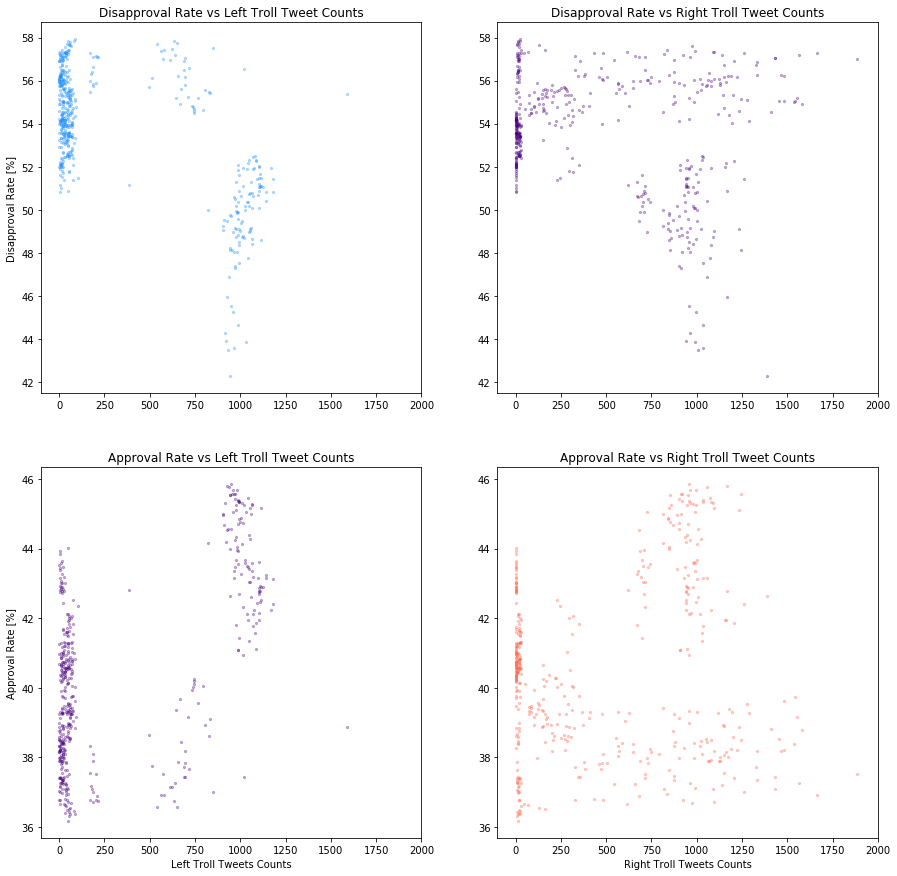

In [0]:
figTweetPolls = plt.figure(figsize=(15,15))

ax1 = figTweetPolls.add_subplot(2,2,1)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='adjusted_disapprove', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Disapproval Rate vs Left Troll Tweet Counts')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Disapproval Rate [%]')
ax1.set_xlim(-100,2000)

ax2 = figTweetPolls.add_subplot(2,2,2)
data_tweet_polls.plot.scatter(x='RightTroll count', y='adjusted_disapprove', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Disapproval Rate vs Right Troll Tweet Counts')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
ax2.set_xlim(-100,2000)

ax3 = figTweetPolls.add_subplot(2,2,3)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='adjusted_approve', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Approval Rate vs Left Troll Tweet Counts')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Approval Rate [%]')
ax3.set_xlim(-100,2000)

ax4 = figTweetPolls.add_subplot(2,2,4)
data_tweet_polls.plot.scatter(x='RightTroll count', y='adjusted_approve', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Approval Rate vs Right Troll Tweet Counts')
ax4.set_xlabel('Right Troll Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
ax4.set_xlim(-100,2000)

plt.show()

In [0]:
data_tweet_polls.corr('spearman')

,adjusted_approve,adjusted_disapprove,RightTroll count,LeftTroll count
adjusted_approve,1.000000,-0.985029,-0.115261,0.427039
adjusted_disapprove,-0.985029,1.000000,0.057874,-0.445731
RightTroll count,-0.115261,0.057874,1.000000,0.389265
LeftTroll count,0.427039,-0.445731,0.389265,1.000000


As visible in the above plot and the corresponding pearson coefficient, there are no clear correlation between number of troll tweets and the polls rate. <br>
However we cannot expect the troll tweet to change the polls drastically up to the percent changes. There are many more factors playing in the poll than just the troll tweets. In consequences, we will look at the polls variation over time and look whether it correltate with troll activity on twitter. To do so we compute the derivative of the polls rate with respect to time:  

#### Variation of approval score

In [0]:
#get the derivative with respect to time for the Clinton and Trump Polls 
data_tweet_polls[['ddisapprove', 'dapprove']] = data_tweet_polls[['adjusted_disapprove','adjusted_approve']].diff()
data_tweet_polls['time_diff'] = data_tweet_polls.index.to_series().diff().dt.days
data_tweet_polls['ddisapprove/dt'] = data_tweet_polls['ddisapprove']/data_tweet_polls['time_diff']
data_tweet_polls['dapprove/dt'] = data_tweet_polls['dapprove']/data_tweet_polls['time_diff']
data_tweet_polls.head(2)

,adjusted_approve,adjusted_disapprove,RightTroll count,LeftTroll count,ddisapprove,dapprove,time_diff,ddisapprove/dt,dapprove/dt
2017-01-20,42.644602,42.271389,1387.0,941.0,NaN,NaN,NaN,NaN,NaN
2017-01-21,43.145552,43.590006,1036.0,964.0,1.318618,0.50095,1.0,1.318618,0.50095


We can now visualize how the polls variation changes with the troll tweets counts : 

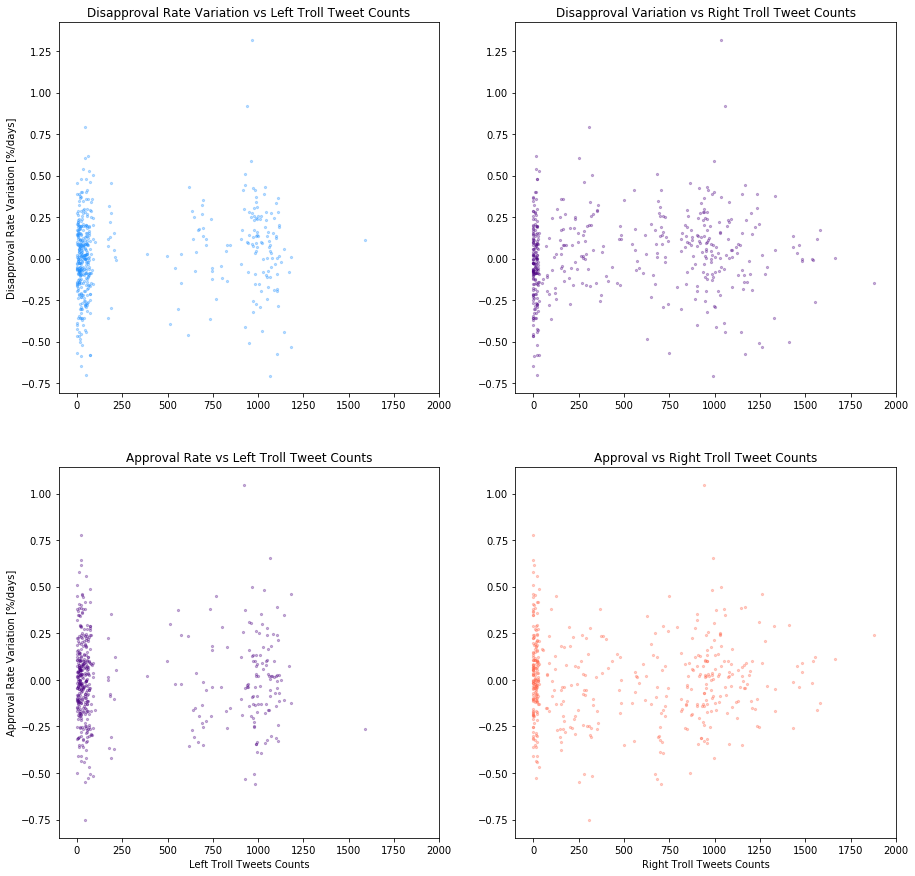

In [0]:
figTweetVarPolls = plt.figure(figsize=(15,15))

ax1 = figTweetVarPolls.add_subplot(2,2,1)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='ddisapprove/dt', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Disapproval Rate Variation vs Left Troll Tweet Counts')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Disapproval Rate Variation [%/days]')
ax1.set_xlim(-100,2000)

ax2 = figTweetVarPolls.add_subplot(2,2,2)
data_tweet_polls.plot.scatter(x='RightTroll count', y='ddisapprove/dt', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Disapproval Variation vs Right Troll Tweet Counts')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
ax2.set_xlim(-100,2000)

ax3 = figTweetVarPolls.add_subplot(2,2,3)
data_tweet_polls.plot.scatter(x='LeftTroll count', y='dapprove/dt', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Approval Rate vs Left Troll Tweet Counts')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Approval Rate Variation [%/days]')
ax3.set_xlim(-100,2000)

ax4 = figTweetVarPolls.add_subplot(2,2,4)
data_tweet_polls.plot.scatter(x='RightTroll count', y='dapprove/dt', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Approval vs Right Troll Tweet Counts')
ax4.set_xlabel('Right Troll Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
ax4.set_xlim(-100,2000)

plt.show()

Here is another way of looking (qualitatively) at it : 

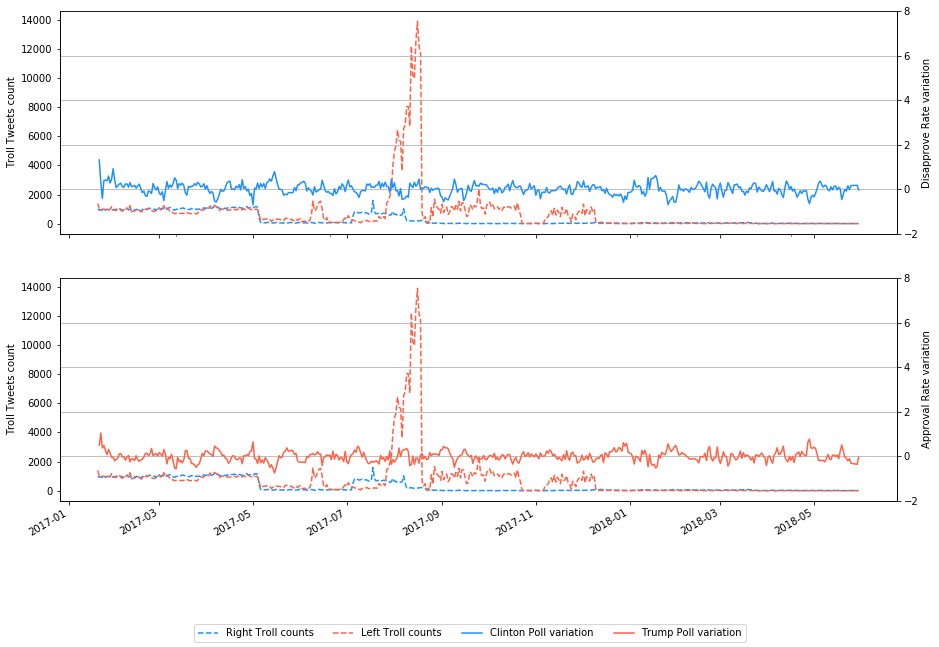

In [0]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax1_2 = ax1.twinx()
data_tweet_polls.loc[:,['LeftTroll count','RightTroll count']].plot(ax=ax1, color=['dodgerblue','tomato'], linestyle='--')
data_tweet_polls.loc[:,['ddisapprove/dt']].plot(ax=ax1_2, color='dodgerblue')
ax1_2.set_ylim(-2,8)
ax1_2.grid(True)
ax1.set_ylabel('Troll Tweets count')
ax1_2.set_ylabel('Disapprove Rate variation')

ax2 = fig.add_subplot(212)
ax2_2 = ax2.twinx()
data_tweet_polls.loc[:,['LeftTroll count','RightTroll count']].plot(ax=ax2, color=['dodgerblue','tomato'], linestyle='--')
data_tweet_polls.loc[:,['dapprove/dt']].plot(ax=ax2_2, color='tomato')
ax2_2.set_ylim(-2,8)
ax2_2.grid(True)
ax2.set_ylabel('Troll Tweets count')
ax2_2.set_ylabel('Approval Rate variation')

ax1.legend().remove()
ax1_2.legend().remove()
ax2.legend().remove()
ax2_2.legend().remove()

fig.legend((ax1.get_lines()[0],ax1.get_lines()[1],ax1_2.get_lines()[0],ax2_2.get_lines()[0]),\
           ('Right Troll counts','Left Troll counts','Clinton Poll variation','Trump Poll variation'),\
           loc = 'lower center', ncol=4 )

plt.show()

In [0]:
data_tweet_polls[['RightTroll count','LeftTroll count','ddisapprove/dt','dapprove/dt']].corr(method='spearman')

,RightTroll count,LeftTroll count,ddisapprove/dt,dapprove/dt
RightTroll count,1.000000,0.389265,0.131656,-0.045466
LeftTroll count,0.389265,1.000000,0.128798,-0.051435
ddisapprove/dt,0.131656,0.128798,1.000000,-0.769303
dapprove/dt,-0.045466,-0.051435,-0.769303,1.000000


#### Number of users reached

Even here, it does not seems that the number of troll tweets correlate with the polls variations. We should look for other variables that may correlate with the polls: we'll start by looking at the number of person directly touched by the tweets (*i.e.* the number of followers). 

We get how many people (the maximum people) are reached everyday by right and left trolls respectively:

In [0]:
people=tweet_data[['publish_date', 'account_category','followers', 'author']]\
            .groupby(by=['publish_date', 'account_category', 'author']).max()\
            .unstack('account_category').fillna(0)\
            .groupby('publish_date').sum()
people.followers.head()

account_category,LeftTroll,RightTroll
publish_date,,
2014-10-18,6.0,0.0
2014-11-25,0.0,84.0
2014-11-26,0.0,84.0
2014-11-28,0.0,84.0
2014-12-01,0.0,98.0


In [0]:
p3 = figure(plot_width=950, plot_height=450, x_axis_type='datetime')
p3.title.text = 'Maximal People directly reached by the tweets'
p3.yaxis.axis_label = 'Tweet density'

source = ColumnDataSource(data=people.followers)
right=p3.line(x='publish_date', y='LeftTroll', line_width=2, alpha=1, legend='Left', color='dodgerblue', source=source)

source = ColumnDataSource(data=people.followers)
left=p3.line(x='publish_date', y='RightTroll', line_width=2, alpha=1, legend='Right', color='tomato', source=source)
p3.legend.location = 'top_left'
p3.legend.click_policy='hide'

hover_tool_R=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%F}'),
        ('People reached','@RightTroll')],
    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'RightTroll' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    mode='vline',
    renderers=[right],
    attachment='above'
)

hover_tool_L=tools.HoverTool(
    tooltips=[
        ('Date', '@publish_date{%F}'),
        ('People reached','@LeftTroll')],
    formatters={
        'publish_date' : 'datetime', # use 'datetime' formatter for 'date' field
        'LeftTrollTroll' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    mode='vline',
    renderers=[left],
    attachment='above'
)

p3.tools.append(hover_tool_R)
p3.tools.append(hover_tool_L)

p4 = figure(plot_width=950, plot_height=450, x_axis_type='datetime')
p4.title.text = 'Tweeting activity according to Right and Left category'
p4.yaxis.axis_label = 'Tweet density'

categories=tweet_data.account_category.unique()
colorplot = ['tomato','dodgerblue']

for color, category in enumerate(categories):
    df_plot = pd.DataFrame(tweet_data[tweet_data.account_category==category].publish_date.value_counts().sort_index())
    source = ColumnDataSource(data=df_plot)
    p4.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend=category, color=colorplot[color])

p4.legend.location = 'top_left'
p4.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%b %d, %Y}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline'
)

p4.tools.append(hover_tool)


#output_notebook()
follower_plot = gridplot([[p3],[p4]])

In [0]:
#show(follower_plot)
output_file(plot_files+'NbUserReached_presidency.html')
save(follower_plot)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/NbUserReached_presidency.html'

Plot can be seen [here](Plots/NbUserReached_presidency.html)

In [0]:
data_follower_polls = data_poll_avg[['adjusted_disapprove','adjusted_approve']].merge(people.followers, left_index=True, right_index=True)
data_follower_polls.head(2)

,adjusted_disapprove,adjusted_approve,LeftTroll,RightTroll
2017-01-20,42.271389,42.644602,167628.0,371765.0
2017-01-21,43.590006,43.145552,149770.0,308236.0


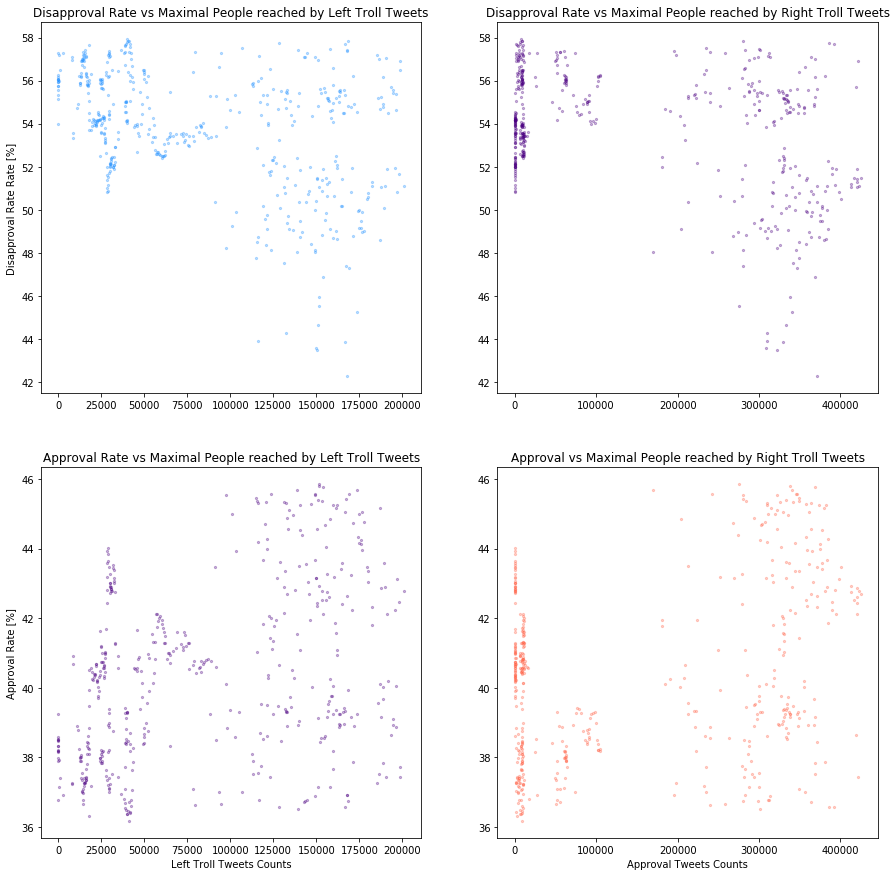

In [0]:
figFollowerPolls = plt.figure(figsize=(15,15))

ax1 = figFollowerPolls.add_subplot(2,2,1)
data_follower_polls.plot.scatter(x='LeftTroll', y='adjusted_disapprove', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Disapproval Rate vs Maximal People reached by Left Troll Tweets')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Disapproval Rate Rate [%]')
#ax1.set_xlim(-100,2000)

ax2 = figFollowerPolls.add_subplot(2,2,2)
data_follower_polls.plot.scatter(x='RightTroll', y='adjusted_disapprove', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Disapproval Rate vs Maximal People reached by Right Troll Tweets')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
#ax2.set_xlim(-100,2000)

ax3 = figFollowerPolls.add_subplot(2,2,3)
data_follower_polls.plot.scatter(x='LeftTroll', y='adjusted_approve', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Approval Rate vs Maximal People reached by Left Troll Tweets')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Approval Rate [%]')
#ax3.set_xlim(-100,2000)

ax4 = figFollowerPolls.add_subplot(2,2,4)
data_follower_polls.plot.scatter(x='RightTroll', y='adjusted_approve', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Approval vs Maximal People reached by Right Troll Tweets')
ax4.set_xlabel('Approval Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
#ax4.set_xlim(-100,2000)

plt.show()

In [0]:
data_follower_polls.corr(method='spearman')

,adjusted_disapprove,adjusted_approve,LeftTroll,RightTroll
adjusted_disapprove,1.000000,-0.985029,-0.387015,-0.240744
adjusted_approve,-0.985029,1.000000,0.380687,0.196713
LeftTroll,-0.387015,0.380687,1.000000,0.768046
RightTroll,-0.240744,0.196713,0.768046,1.000000


In [0]:
data_follower_dpolls = data_follower_polls.merge(data_tweet_polls[['ddisapprove/dt','dapprove/dt']], right_index=True, left_index=True)
data_follower_dpolls.head()

,adjusted_disapprove,adjusted_approve,LeftTroll,RightTroll,ddisapprove/dt,dapprove/dt
2017-01-20,42.271389,42.644602,167628.0,371765.0,NaN,NaN
2017-01-21,43.590006,43.145552,149770.0,308236.0,1.318618,0.500950
2017-01-22,43.888456,44.193660,116343.0,309386.0,0.298449,1.048107
2017-01-23,43.478335,44.570419,150331.0,321876.0,-0.410120,0.376760
2017-01-24,43.865453,45.051454,166711.0,329753.0,0.387118,0.481034


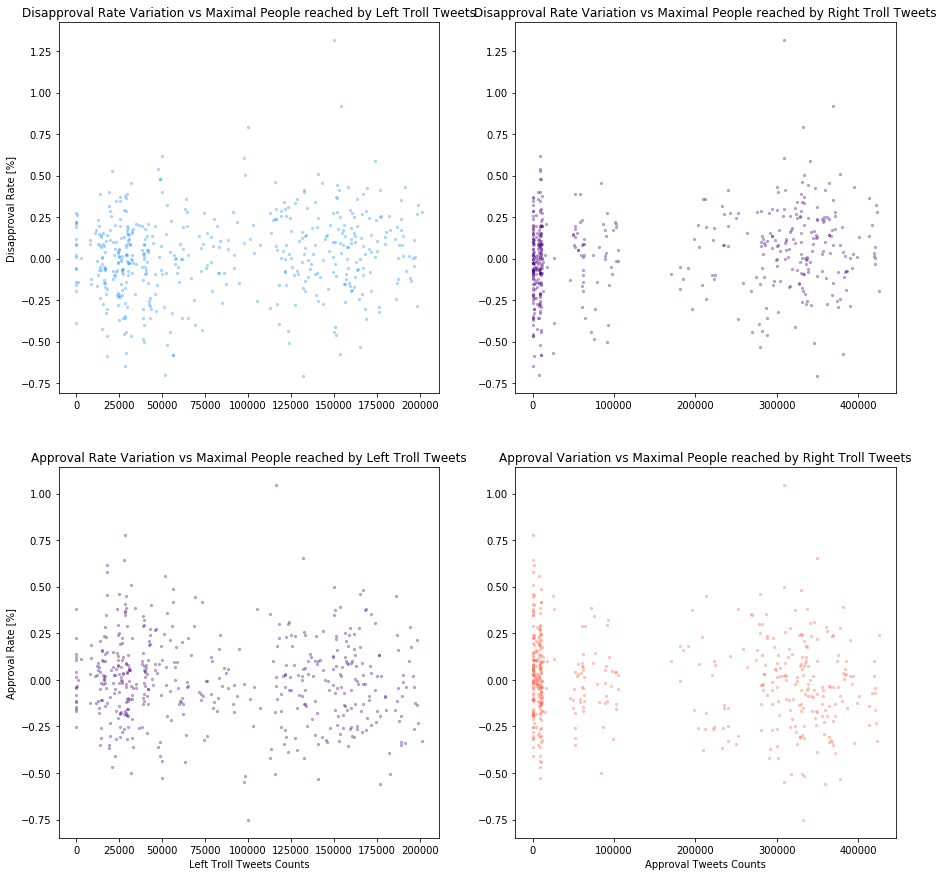

In [0]:
figFollower_dPolls = plt.figure(figsize=(15,15))

ax1 = figFollower_dPolls.add_subplot(2,2,1)
data_follower_dpolls.plot.scatter(x='LeftTroll', y='ddisapprove/dt', ax=ax1, color='dodgerblue',marker='.',alpha=0.3, legend=False)
ax1.set_title('Disapproval Rate Variation vs Maximal People reached by Left Troll Tweets')
ax1.set_xlabel('')#'Left Troll Tweets Counts')
ax1.set_ylabel('Disapproval Rate [%]')
#ax1.set_xlim(-100,2000)

ax2 = figFollower_dPolls.add_subplot(2,2,2)
data_follower_dpolls.plot.scatter(x='RightTroll', y='ddisapprove/dt', ax=ax2, color='indigo',marker='.',alpha=0.3, legend=False)
ax2.set_title('Disapproval Rate Variation vs Maximal People reached by Right Troll Tweets')
ax2.set_xlabel('')#'Right Troll Tweets Counts')
ax2.set_ylabel('')#'Clinton Polls Rate [%]')
#ax2.set_xlim(-100,2000)

ax3 = figFollower_dPolls.add_subplot(2,2,3)
data_follower_dpolls.plot.scatter(x='LeftTroll', y='dapprove/dt', ax=ax3, color='indigo',marker='.',alpha=0.3, legend=False)
ax3.set_title('Approval Rate Variation vs Maximal People reached by Left Troll Tweets')
ax3.set_xlabel('Left Troll Tweets Counts')
ax3.set_ylabel('Approval Rate [%]')
#ax3.set_xlim(-100,2000)

ax4 = figFollower_dPolls.add_subplot(2,2,4)
data_follower_dpolls.plot.scatter(x='RightTroll', y='dapprove/dt', ax=ax4, color='tomato',marker='.',alpha=0.3, legend=False)
ax4.set_title('Approval Variation vs Maximal People reached by Right Troll Tweets')
ax4.set_xlabel('Approval Tweets Counts')
ax4.set_ylabel('')#'Trump Polls Rate [%]')
#ax4.set_xlim(-100,2000)

plt.show()

In [0]:
data_follower_dpolls.corr(method='spearman')

,adjusted_disapprove,adjusted_approve,LeftTroll,RightTroll,ddisapprove/dt,dapprove/dt
adjusted_disapprove,1.000000,-0.985029,-0.387015,-0.240744,-0.088255,-0.009704
adjusted_approve,-0.985029,1.000000,0.380687,0.196713,0.085275,0.015201
LeftTroll,-0.387015,0.380687,1.000000,0.768046,0.125892,-0.082131
RightTroll,-0.240744,0.196713,0.768046,1.000000,0.192738,-0.139781
ddisapprove/dt,-0.088255,0.085275,0.125892,0.192738,1.000000,-0.769303
dapprove/dt,-0.009704,0.015201,-0.082131,-0.139781,-0.769303,1.000000


### Topic

We now examine the potential correlation between the polls and the topics. The topics were previously defined in the `WebScrap.ipynb`. The number of tweet per day for each topic is compared with the approval score for each candidate.

In [0]:
def load_topic_df(filename=pickle_files +'topic_df.plk'):
    """Load the pickle generated in the WebScrap.ipynb
    Contains: the tweet content, the publish_data, the topics"""
    with open(filename, 'rb') as df_top:
            df_topic=pickle.load(df_top) 
        
    print("Df topic loaded <---")
    
    return df_topic        

In [0]:
#loading data
df_topic=load_topic_df()
df_topic.columns

Df topic loaded <---


Index(['publish_date', 'content', 'account_category', 'Clean_tweet',
       'hashtags', 'Mentioned', 'Music', 'Movies', 'Sport', 'Trump', 'Hillary',
       'Hacking', 'Sanders', 'Obama', 'Election', 'Voter', 'Healthcare',
       'Gouvernment', 'Religion', 'Conservative', 'Liberal', 'Gun',
       'Terrorism', 'Fear', 'BlackLivesMatter', 'MeToo', 'FakeNews', 'News',
       'Scandal', 'Charlottesville', 'Economy', 'Categorical'],
      dtype='object')

In [0]:
#selecting relevant columns
df_topic=df_topic.drop(columns={'content', 'Clean_tweet', 'hashtags','Categorical','Charlottesville', 'Election' })
print('\nThe {} topics are:\n    {}'.format(len(df_topic.columns[2:]), '\n    '.join([topic for topic in df_topic.columns[2:].tolist()])))


The 24 topics are:
    Mentioned
    Music
    Movies
    Sport
    Trump
    Hillary
    Hacking
    Sanders
    Obama
    Voter
    Healthcare
    Gouvernment
    Religion
    Conservative
    Liberal
    Gun
    Terrorism
    Fear
    BlackLivesMatter
    MeToo
    FakeNews
    News
    Scandal
    Economy


In [0]:
df_poll_topic= data_poll_avg.drop(columns={'samplesize','weight','influence', 'approve','disapprove','poll_id'})
#Get the count of tweet per day for each category
df_topic=df_topic.groupby(by=['account_category','publish_date']).sum().unstack("account_category").fillna(0)

In [0]:
df_poll_topic.head()

,adjusted_approve,adjusted_disapprove
startdate,,
2017-01-20,42.644602,42.271389
2017-01-21,43.145552,43.590006
2017-01-22,44.193660,43.888456
2017-01-23,44.570419,43.478335
2017-01-24,45.051454,43.865453


Merging the polls data and the topic tweet count per day.

In [0]:
df_scatter=df_poll_topic.merge(df_topic, how='inner', right_index=True, left_index=True)
topic_selected=df_scatter.columns.tolist()[2:]
#Renaming columns
df_scatter.columns= df_scatter.columns[:2].tolist()+ [t[0]+'_'+t[1] for t in topic_selected]

/Users/nicolasgandar/anaconda3/envs/ada/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [0]:
df_scatter.head()

,adjusted_approve,adjusted_disapprove,Music_LeftTroll,Music_RightTroll,Movies_LeftTroll,Movies_RightTroll,Sport_LeftTroll,Sport_RightTroll,Trump_LeftTroll,Trump_RightTroll,...,MeToo_LeftTroll,MeToo_RightTroll,FakeNews_LeftTroll,FakeNews_RightTroll,News_LeftTroll,News_RightTroll,Scandal_LeftTroll,Scandal_RightTroll,Economy_LeftTroll,Economy_RightTroll
2017-01-20,42.644602,42.271389,127.0,13.0,15.0,8.0,3.0,6.0,142.0,578.0,...,19.0,11.0,11.0,37.0,22.0,112.0,0.0,3.0,4.0,13.0
2017-01-21,43.145552,43.590006,92.0,12.0,21.0,6.0,5.0,9.0,125.0,388.0,...,119.0,126.0,16.0,52.0,27.0,83.0,1.0,1.0,2.0,9.0
2017-01-22,44.193660,43.888456,93.0,11.0,17.0,4.0,7.0,20.0,113.0,287.0,...,113.0,164.0,12.0,47.0,25.0,85.0,1.0,1.0,4.0,19.0
2017-01-23,44.570419,43.478335,116.0,13.0,31.0,13.0,8.0,5.0,99.0,324.0,...,53.0,110.0,22.0,51.0,22.0,113.0,2.0,1.0,5.0,36.0
2017-01-24,45.051454,43.865453,123.0,13.0,40.0,10.0,2.0,6.0,96.0,341.0,...,43.0,59.0,16.0,39.0,25.0,119.0,0.0,3.0,7.0,40.0


**Plotting and Correlation computing**

The Spearman correlation coefficient is computed.

In [0]:
p_dl = figure(plot_width=800, plot_height=600, y_range=(0,1000))
p_dr=figure(plot_width=800, plot_height=600, y_range=(0,1000))

p_ar=figure(plot_width=800, plot_height=600, y_range=(0,1000))
p_al = figure(plot_width=800, plot_height=600, y_range=(0,1000))


colors= ['darkolivegreen', 'darkmagenta','tomato', 'dodgerblue', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkolivegreen']

source=ColumnDataSource(data=df_scatter)

df_corr=pd.DataFrame()

for color, topic in enumerate(df_topic.columns.levels[0]):
    
    #correlation
    df_corr.loc[topic,'Dl']=df_scatter.loc[:, [topic+'_LeftTroll', 'adjusted_disapprove']].corr(method='spearman').values.flatten()[1]
    df_corr.loc[topic,'Al']=df_scatter.loc[:, [topic+'_LeftTroll', 'adjusted_approve']].corr(method='spearman').values.flatten()[1]
    df_corr.loc[topic,'Ar']=df_scatter.loc[:, [topic+'_RightTroll', 'adjusted_approve']].corr(method='spearman').values.flatten()[1]
    df_corr.loc[topic,'Dr']=df_scatter.loc[:, [topic+'_RightTroll', 'adjusted_disapprove']].corr(method='spearman').values.flatten()[1]
    
    #plotting
    p_dl.scatter(x='adjusted_disapprove', y=topic+'_LeftTroll', source=source, legend=topic, color=colors[color])
    p_dl.yaxis.axis_label = 'LeftTroll'
    p_dl.xaxis.axis_label='Disapproval'
    
   
    p_dr.scatter(x='adjusted_disapprove', y=topic+'_RightTroll', source=source, legend=topic, color=colors[color])
    p_dr.yaxis.axis_label = 'RightTroll'
    p_dr.xaxis.axis_label='Disapproval'
    
    p_al.scatter(x='adjusted_approve', y=topic+'_LeftTroll', source=source, legend=topic, color=colors[color])
    p_al.yaxis.axis_label = 'LeftTroll'
    p_al.xaxis.axis_label='Approval'
    
    
    p_ar.scatter(x='adjusted_approve', y=topic+'_RightTroll', source=source, legend=topic, color=colors[color])
    p_ar.yaxis.axis_label = 'RightTroll'
    p_ar.xaxis.axis_label='Approval'
    
    p_dl.legend.click_policy='hide'
    p_dr.legend.click_policy='hide'
    p_al.legend.click_policy='hide'
    p_ar.legend.click_policy='hide'
    

p_ar.legend.location = 'top_left'
p_ar.legend.orientation = "vertical"
p_ar.legend.label_text_font_size="12pt"

p_dl.legend.location = 'top_left'
p_dl.legend.orientation = "vertical"
p_dl.legend.label_text_font_size="12pt"

p_dr.legend.location = 'top_left'
p_dr.legend.orientation = "vertical"
p_dr.legend.label_text_font_size="12pt"


p_dl.legend.location = 'top_left'
p_dl.legend.orientation = "vertical"
p_dl.legend.label_text_font_size="12pt"

grid=column([p_dl, p_dr, p_ar, p_al])
#output_notebook()

In [0]:
output_file(plot_files+'Approval_Topic.html')
save(grid)

'/Users/nicolasgandar/Desktop/EPFL/ADA/Projet/ADA-Proj-18/Plots/Approval_Topic.html'

The plot can be find [here](Plots/Approval_Topic.html). 

In [0]:
#show(grid)

In [0]:
df_corr.index.name='topic'
df_corr.to_csv(csv_files+'CorrelationApporval_topic.csv')
df_corr

,Dl,Al,Ar,Dr
topic,,,,
Music,-0.447671,0.420091,0.132861,-0.180913
Movies,-0.413920,0.400917,0.251860,-0.299315
Sport,-0.436406,0.421132,0.199998,-0.250952
Trump,-0.481490,0.477656,-0.119054,0.064999
Hillary,-0.440067,0.430648,-0.222770,0.159540
Hacking,-0.451236,0.440304,0.034918,-0.080842
Sanders,-0.091454,0.087870,0.184668,-0.201795
Obama,-0.486515,0.468055,-0.025845,-0.026216
Voter,-0.371863,0.363081,0.021252,-0.055052


Saving to csv.

In [0]:
df_scatter.index.name='date'
df_scatter.to_csv(csv_files+'Scatter_Polls_Topics_Pesidency.csv')

**The extended list is here.** Note that the words are stemmed. For instance, the sufixes *'ing', 's', 'e'* are removed.

In [0]:
print('#-Topic-# : {} '.format('\n-----\n#-Topic-# : '.join([str(topic) for topic in topic_extended])))

#-Topic-# : ['Music', 'music', 'hip-hop', 'newmus', 'countrymus', 'music', 'jcole', 'tidalhifi', 'lyric', 'ep', 'platinum', 'chancetherapp', 'okayplay', 'tidalhifi', 'album', 'songwrit', 'self-taught', 'musician', 'feat', 'rapstationradio', 'nowplay', 'datpiff', 'rt74', 'soundcloud', 'getthisrap', 'rapup', 'yooo', 'rap', 'djkingassassin', 'musicmoney', 'bumpin', 'winnin', 'wewinnin', 'asvpxrocki', 'mixcloud', 'futureofnewyork', 'bwdradio', 'studiolif', 'fuego', 'mikewillmadeit', 'kingbon', 'hiphopbeat', 'finallevel', 'snippet', 'jermainedupri', 'realsway', 'bbeloudpackteam', 'djquestgh', 'djhivolum', 'blaq', 'hiphopmus', 'outro', 'starboy', 'iamkrson', 'gitbukk', 'nervedjsmixtap', 'vidasunshyn', 'therealkiss', 'rnb', 'okayplay', 'duo', 'tidalhifi', 'rampb', 'indiespotlight', 'storytel', 'music', 'variant', 'boogabradshaw', 'ballerina', 'emce', 'yarashahidi', 'jazz', 'spitter', 'opera', 'donaldglov', 'hip-hop', 'eminem', 'trvisxx', 'sade', 'quavostuntin', 'wizkhalifa', 'mikewillmadeit',